<a href="https://colab.research.google.com/github/kittisaktaoma/GO-tools-comparsion/blob/master/GO_tools_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and prepare package

In [ ]:
install.packages(c("data.table","factoextra"))
install.packages(c("Himsc")) 
install.packages(c("ComplexHeatmap")) 
install.packages(c("klaR","splitstackshape"))
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
library(devtools)
install_github("omegahat/XML")
install_github("harrelfe/Hmisc")
install_github("jokergoo/ComplexHeatmap")
BiocManager::install("GSEABase")
BiocManager::install("GO.db")
install.packages("pheatmap")
install.packages("irr")

In [113]:
install.packages("dendextend")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [114]:
library(dendextend)
library(ggplot2)
library(data.table)
library(factoextra)
library(dplyr)
library(data.table)
library(corrplot)
library(RColorBrewer)
library(Hmisc)
library(ggrepel)
library(ComplexHeatmap)
library(devtools)
library(ggpubr)
library(reshape2)
library(klaR)
library(purrr)
library(splitstackshape)
library(broom)
library(circlize)
library(GSEABase)
library(GO.db)
library(rstatix)
library(tidyverse)
library(irr)


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:ggpubr’:

    rotate


The following object is masked from ‘package:data.table’:

    set


The following object is masked from ‘package:stats’:

    cutree




# **SEA characteristics of 10 GO annotation and enrichment analysis tools** 

## Binary Heatmap

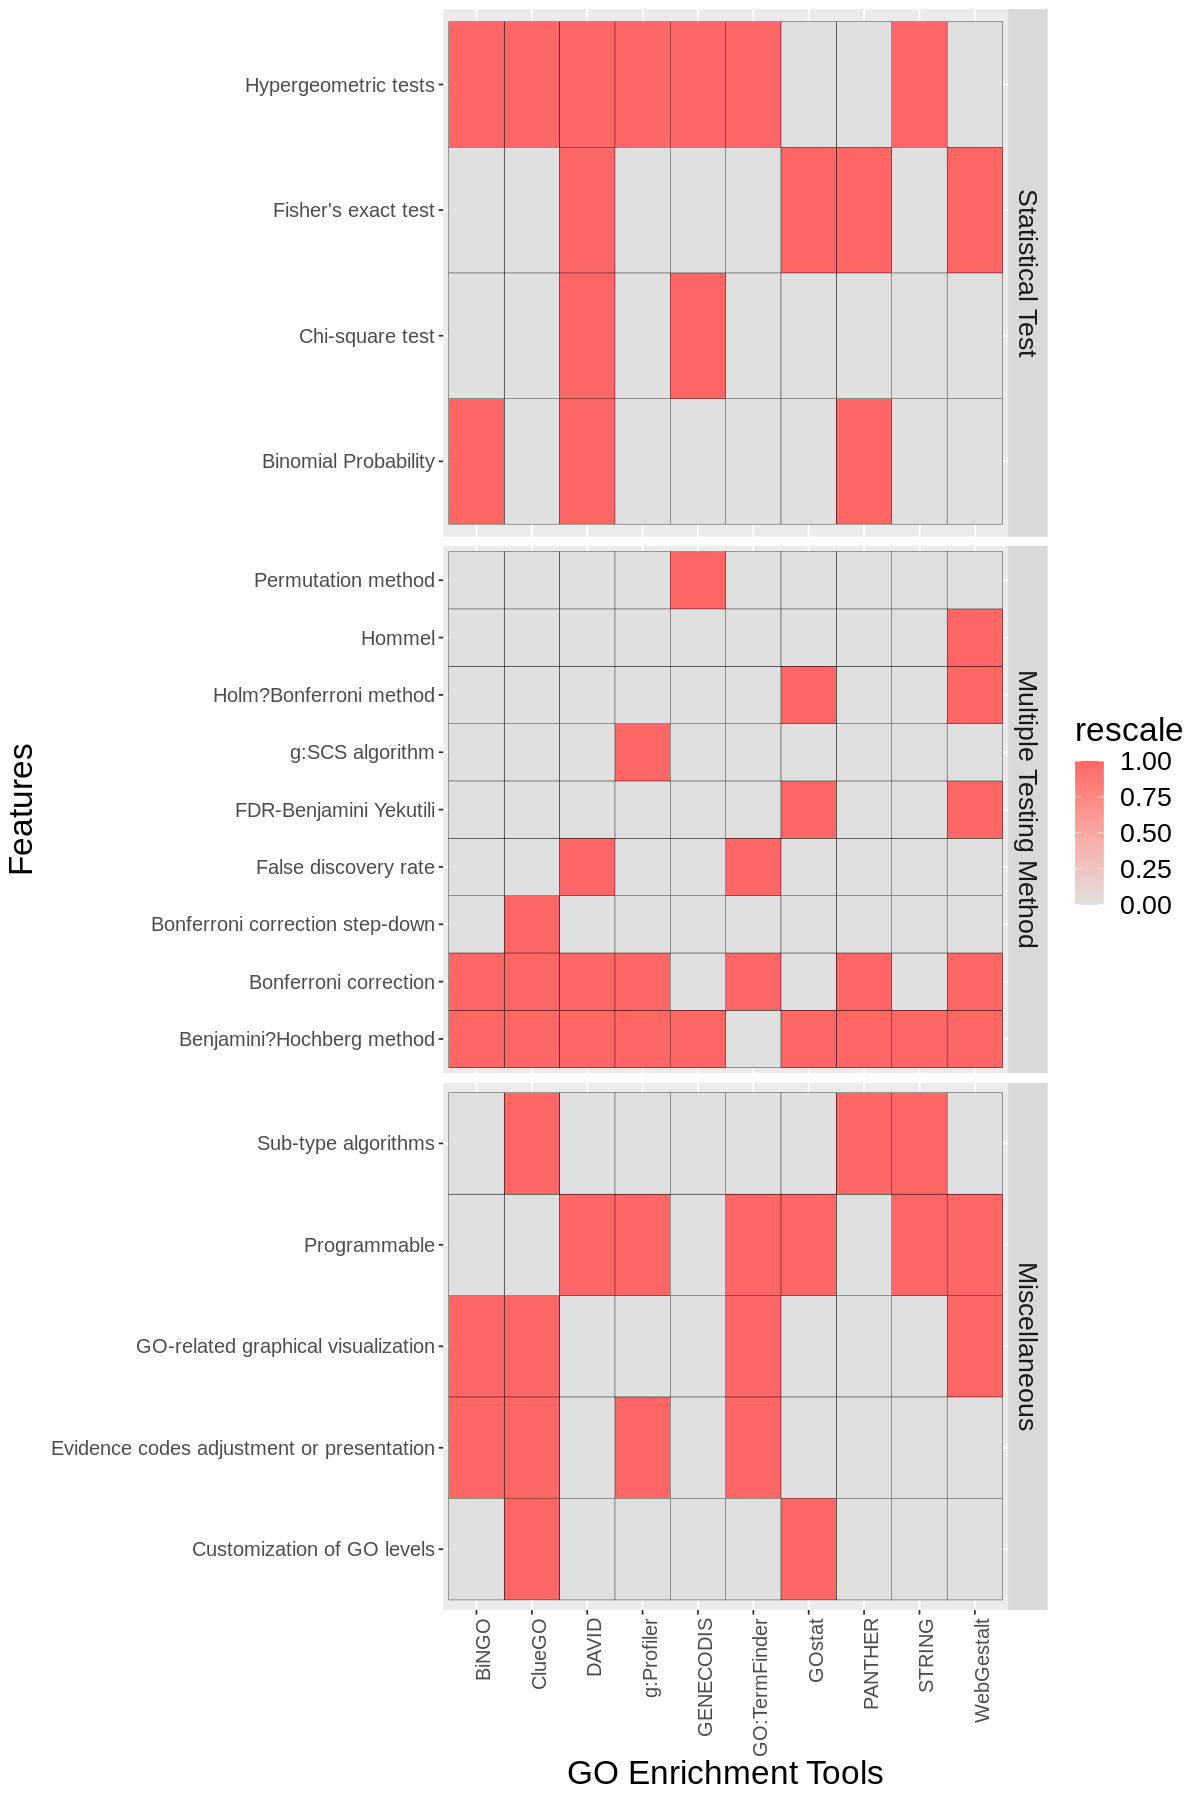

In [ ]:
# Characteristics 
df1.m <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Characteristics.txt")
df1.m$type <- factor(df1.m$type, levels = c("Statistical Test","Multiple Testing Method","Miscellaneous"))
# Make plots wider 
options(repr.plot.width=10, repr.plot.height=15)
ggplot(df1.m, aes(x=Database, y=variable)) +
  geom_tile(aes(fill = rescale), colour = "black") +
  scale_fill_gradient(low = "#E0E0E0", high = "#FF6666") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(colors = "") +theme(axis.text=element_text(size=12)) +
  ylab("Features") +
  xlab("GO Enrichment Tools") +
  facet_grid(type ~ .,scales = "free") + 
  theme(strip.text.x = element_text(size = 20))+
  theme(text = element_text(size=20),
        axis.text.x = element_text(angle=90, hjust=1)) 



## K-mean clustering

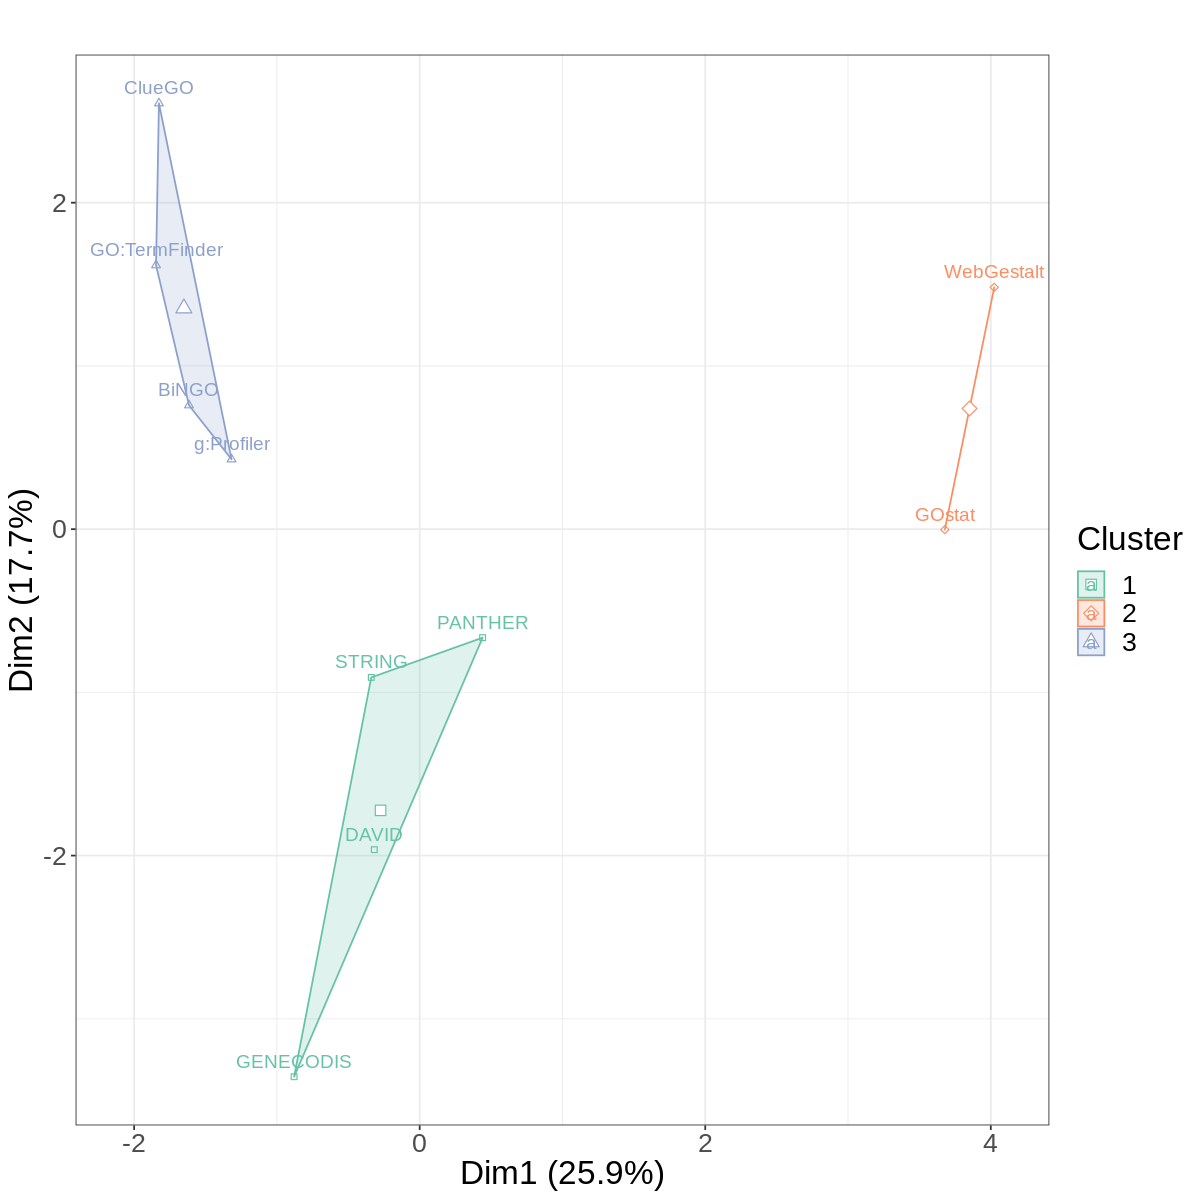

In [ ]:

kdf <-  fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Tools_Properties_Binary.csv") %>% as.data.frame()
df.01 <- kdf[,-1]
rownames(df.01) <- kdf[,1]


res.pca <- prcomp(df.01)
ind.coord <- res.pca$x
df <- ind.coord %>% as.data.frame()

# function to compute total within-cluster sum of square 
wss <- function(k) {
  kmeans(df, k, nstart = 2 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:8

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

#plot(k.values, wss_values,
#     type="b", pch = 19, frame = FALSE, 
#    xlab="Number of clusters K",
#    ylab="Total within-clusters sum of squares")


final <- kmeans(df.01, 3, nstart = 2)
# Make plots wider 
options(repr.plot.width=10, repr.plot.height=10)
fviz_cluster(final, data = df.01) +
  theme_bw() +
  xlim(-2.1,4.1)  +
  scale_color_brewer('Cluster', palette='Set2') + 
  scale_fill_brewer('Cluster', palette='Set2') +
  scale_shape_manual('Cluster', values=c(22,23,24)) + 
  ggtitle(label='')+
  theme(text = element_text(size=20)) 

# **The proportion of identified GO term in three categories**


In [197]:
df_01 <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% filter(.,Enrichment == "All (Up vs. Down)")
head(df_01)

GOID,Description,FDR,Database,Type,Genes,Enrichment,Group
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBAL3,All (Up vs. Down),EGCG
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,ACTL6B,All (Up vs. Down),EGCG
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBB6,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,CAV1,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMC4,All (Up vs. Down),EGCG
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMA5,All (Up vs. Down),EGCG


## Plot Frequency (Sig and Non. Sig)

`summarise()` regrouping output by 'Database', 'Group', 'Type' (override with `.groups` argument)



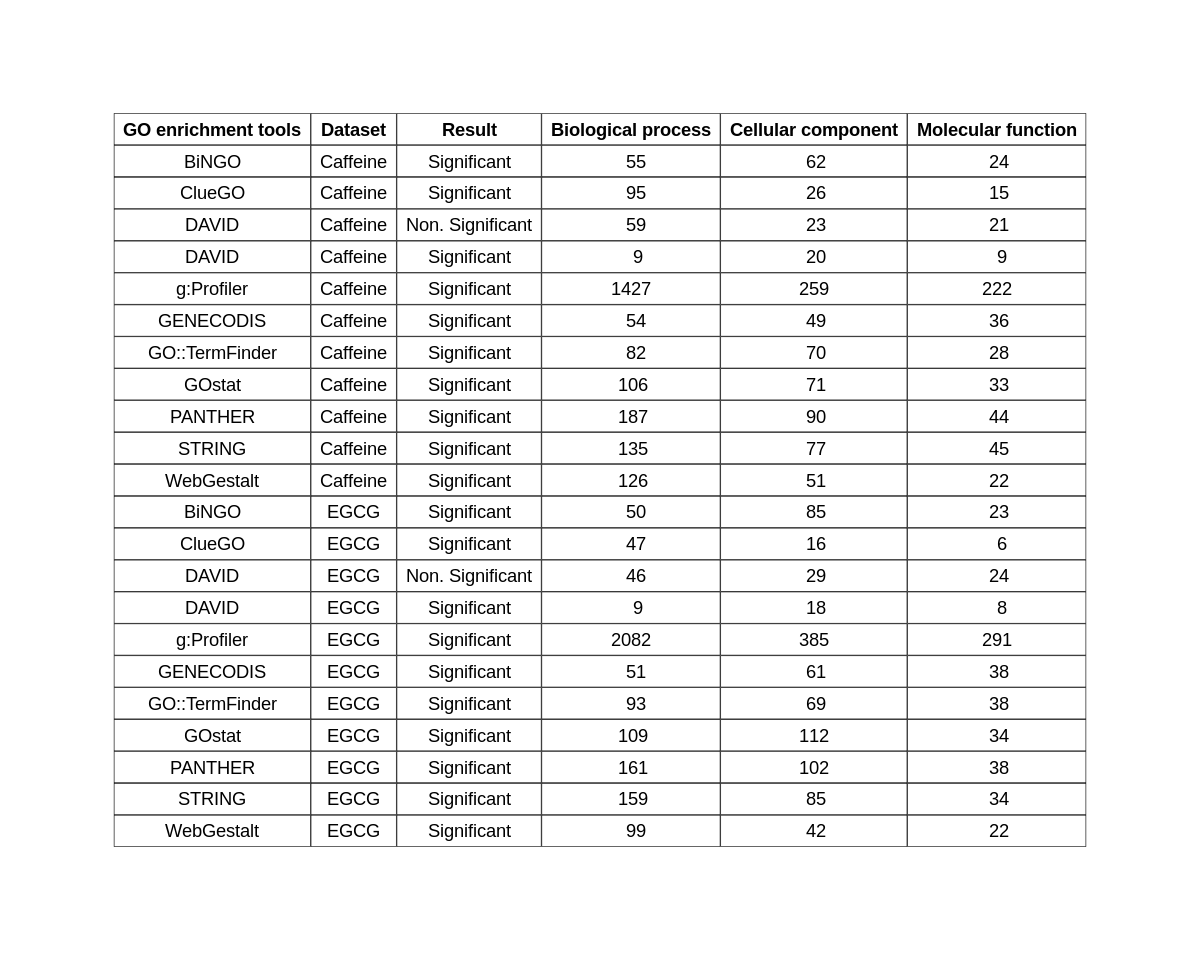

In [181]:
# Plot Frequency
df_01$Condition <- ifelse(df_01$FDR < 0.05,"Significant","Non. Significant")

##Count and Plot

##Count
count <- df_01[,-6] %>% unique() %>% group_by(Database,Group,Type,Condition) %>% dplyr::summarise(count=n()) %>% as.data.frame()
resh <- reshape(count, idvar = c("Database","Group","Condition"), timevar = "Type", direction = "wide")
resh.01 <-resh[order(resh$Group),]
names(resh.01) <- c("GO enrichment tools",
                    "Dataset",
                    "Result",
                    "Biological process",
                    "Cellular component",
                    "Molecular function")

ggtexttable(resh.01, rows = NULL, theme = ttheme("classic"))


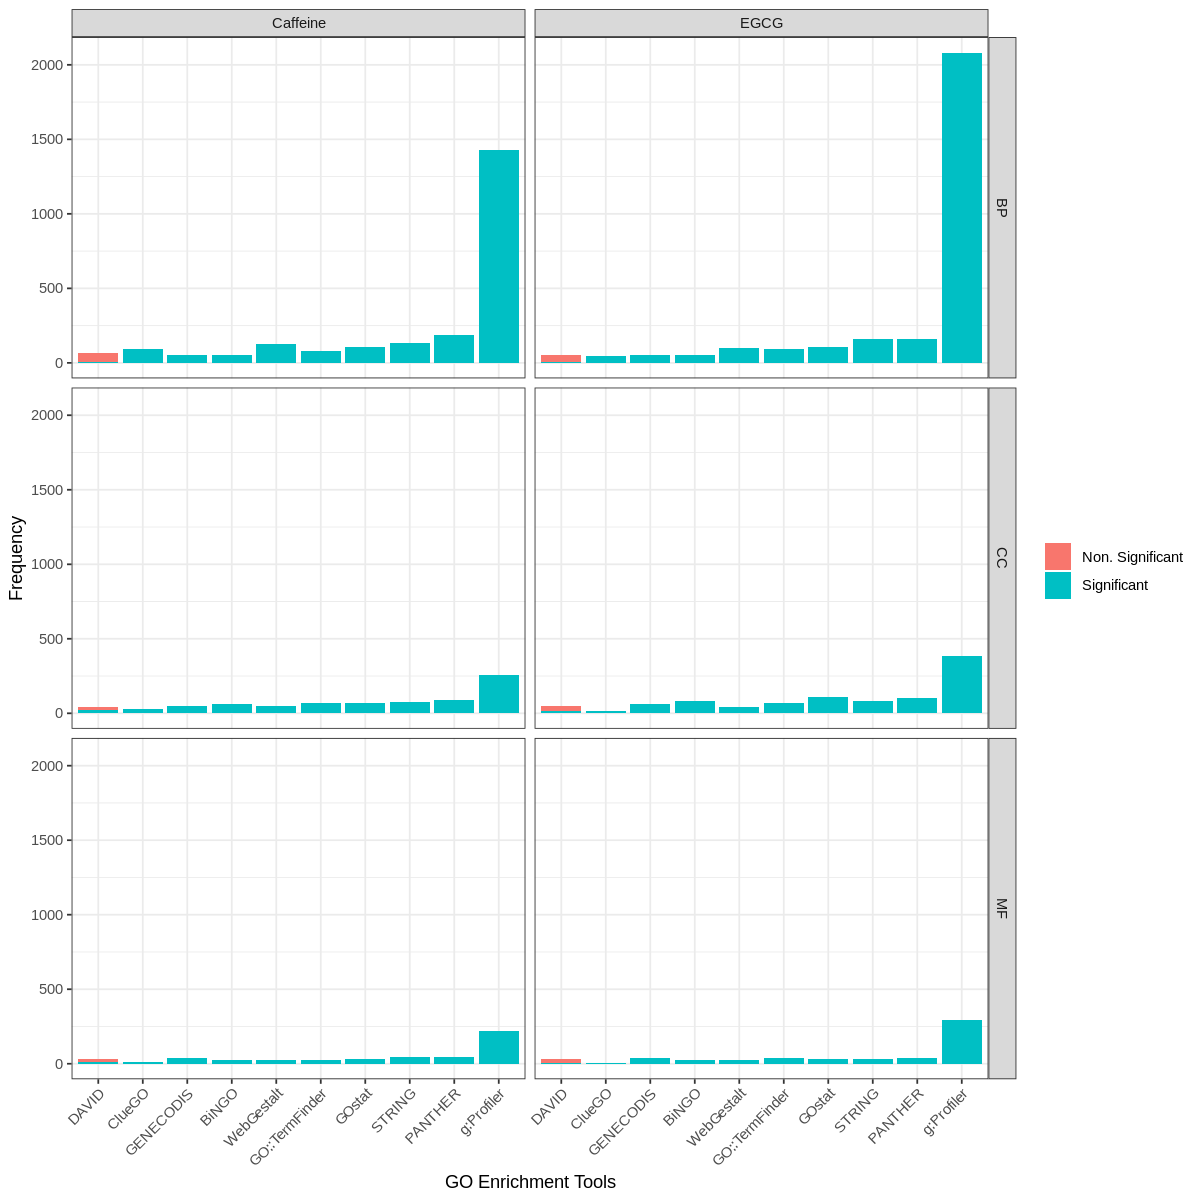

In [182]:
##Plot
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=count, aes(x=reorder(Database,count), y=count, fill=Condition)) +
  geom_bar(stat="identity") +
  theme_bw() +
  facet_grid(vars(Type), vars(Group)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(fill = "") +
  xlab("GO Enrichment Tools") +
  ylab("Frequency")


## Plot Frequency of BP, MF, CC between Caffeine and EGCG (Sig. Only)

In [183]:
round_df <- function(df, digits, rf="round") {
  
  if(  missing(df) ){  
    stop("df not set", call. = F) 
  }else if(!is.data.frame(df)){
    stop("df must be a dataframe", call.=F)
  }
  
  if(missing(digits)){
    digits <- 0
  }else if(!is.numeric( digits )){
    stop( "'digits' must be numeric", call.=F)
  }else if(length(digits)!=1){
    stop("length of 'digits' must be 1", call.=F)
  }else if(! digits > -10 | ! digits <= 10){
    stop("'digits' must be a number between -10 and 10", call.=F)
  }
  
  if(!is.character( rf )){
    stop( "'rf' must be character", call.=F)
  }else if(length(rf)!=1){
    stop("Length of 'rf' must be 1", call.=F)
  }else if(! rf %in% c('round', 'ceiling', 'floor', 'trunc', 'signif') ){ 
  stop("'rf' must be equal to 'round', 'ceiling', 'trunc', 'floor' or 'signif' ", call. = F) 
  }
  
  numeric_columns <- sapply(df, class) == 'numeric'
  
  if(rf=="round"){
  
  df[numeric_columns] <-  round(df[numeric_columns], digits)
  
  }else if(rf=="ceiling"){
    
    df[numeric_columns] <-  ceiling(df[numeric_columns])
    
  }else if(rf=="floor"){
    
    df[numeric_columns] <-  floor(df[numeric_columns])
    
  }else if(rf=="trunc"){
    
    df[numeric_columns] <-  ceiling(df[numeric_columns])
    
  }else if(rf=="signif"){
    
    df[numeric_columns] <-  signif(df[numeric_columns], digits)
    
  }
  
  df
}

`summarise()` regrouping output by 'Database', 'Group' (override with `.groups` argument)



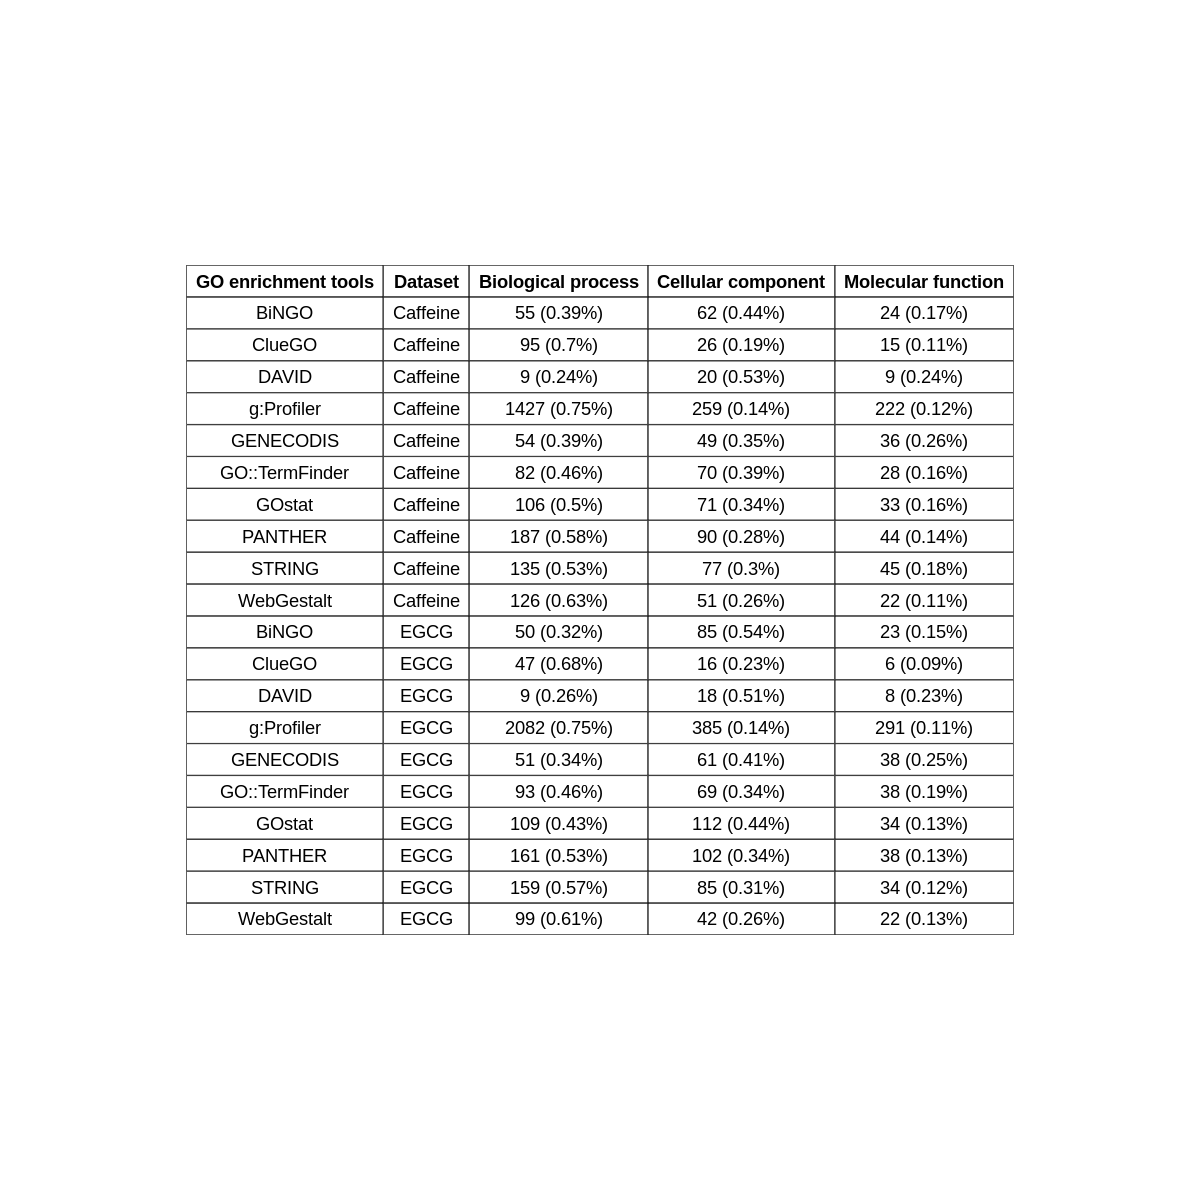

In [184]:
count_02 <-df_01[,-6] %>% unique() %>% filter(.,Condition == "Significant") %>% group_by(Database,Group,Type) %>% dplyr::summarise(count=n()) %>% as.data.frame() 
resh <- reshape(count_02, idvar = c("Database","Group"), timevar = "Type", direction = "wide")
resh.01 <-resh[order(resh$Group),]
names(resh.01) <- c("GO enrichment tools",
                    "Dataset",
                    "Biological process",
                    "Cellular component",
                    "Molecular function")

resh.02 <- cbind(resh.01[,c(1,2)], prop.table(as.matrix(resh.01[,-c(1,2)]), margin = 1))
resh.02[,c(3:5)] <- round_df(resh.02[,c(3:5)], digits=2)

all_non <- cbind(resh.01,resh.02)[,-c(6,7)] 
all_non$`Biological process` <- paste0(all_non$`Biological process`," ","(",all_non$`Biological process.1`,"%",")")
all_non$`Cellular component` <- paste0(all_non$`Cellular component`," ","(",all_non$`Cellular component.1`,"%",")")
all_non$`Molecular function` <- paste0(all_non$`Molecular function`," ","(",all_non$`Molecular function.1`,"%",")")

all_non.final <- all_non[,-c(6,7,8)]
#reshape(all_non.final, idvar = "GO enrichment tools", timevar = "Dataset", direction = "wide")
ggtexttable(all_non.final, rows = NULL, theme = ttheme("classic"))


In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data=count_02, aes(x=reorder(Database,count), y=count, fill=Type)) +
  geom_bar(stat="identity", color="black", position=position_dodge()) +
  theme_bw() +
  facet_grid(cols=vars(Group)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(fill = "")+
  xlab("GO Enrichment Tools") +
  ylab("Frequency")+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1)) +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                                "Cellular Component",
                                                "Molecular Function"))

`summarise()` regrouping output by 'Database', 'Dataset' (override with `.groups` argument)



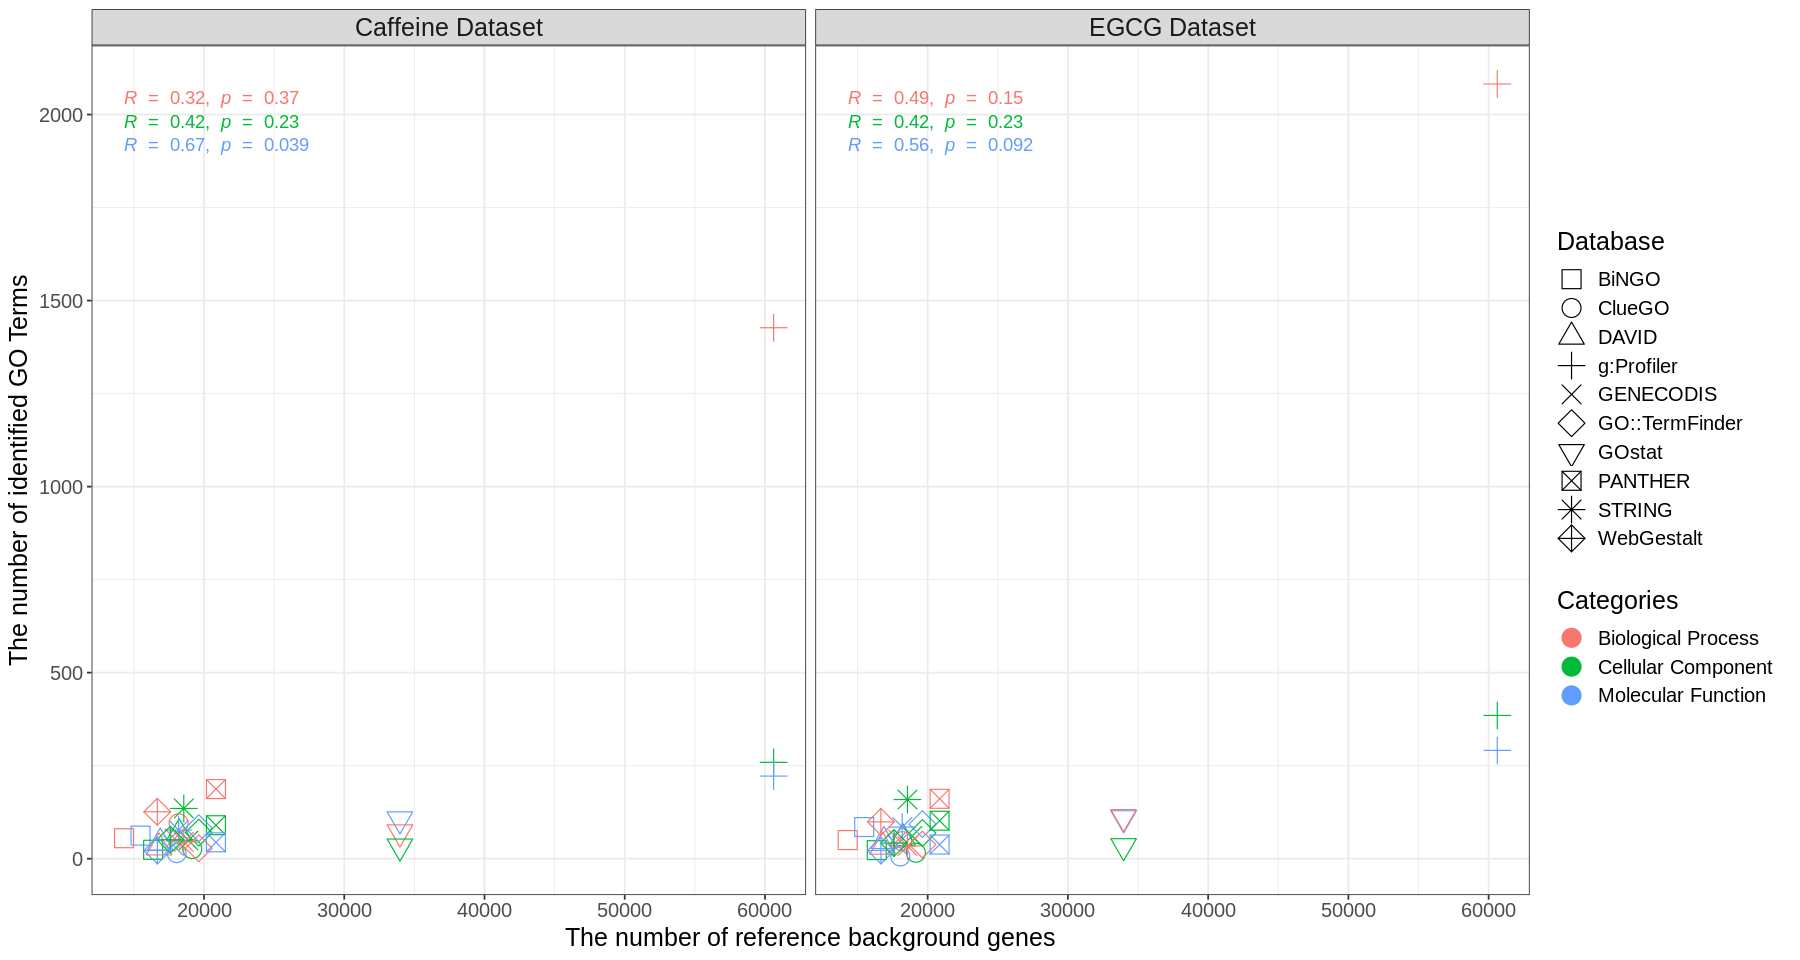

In [210]:
df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Reference-Count.txt") %>% as.data.frame()

all <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% setnames("Group","Dataset")
all.01 <- all %>% filter(.,Enrichment == "All (Up vs. Down)")


df.01 <- df[with(df, order(Database,Dataset)), ]
df.all <- all.01[,-6] %>% unique() %>% group_by(Database,Dataset,Type) %>% 
  dplyr::summarise(CNT=n()) %>% as.data.frame() 
df.all.01 <- df.all[with(df.all, order(Database,Dataset)), ]

c.df <- cbind(df.01,df.all.01)[,-c(5,6,7)]

options(repr.plot.width=15, repr.plot.height=8)
ggplot(c.df,aes(back,CNT,color=Categories)) +
  geom_point(aes(shape=Database),size=5) + 
  scale_shape_manual(values=seq(0,10)) +
  facet_grid(cols=vars(Dataset))  +
  theme_bw() +
 stat_cor(method="spearman") +
  xlab("The number of reference background genes") +
  ylab("The number of identified GO Terms")+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))


## GO proportion

In [203]:
chi <- df_01[,-6] %>% unique() %>% filter(.,FDR < 0.05) %>% dplyr::select(Database,Type,Group)  
chi_02 <- table(chi$Database,chi$Type,chi$Group) %>% as.data.frame()
chi_03 <- reshape(chi_02, idvar = c("Var1","Var3"), timevar = "Var2", direction = "wide") 
names(chi_03) <- c("Database","Dataset","BP","CC","MF")
chi_4 <- cbind(chi_03[,c(1,2)], prop.table(as.matrix(chi_03[,-c(1,2)]), margin = 1)) %>% melt(.)
head(chi_4)

Using Database, Dataset as id variables



,Database,Dataset,variable,value
,<fct>,<fct>,<fct>,<dbl>
1,BiNGO,Caffeine,BP,0.3900709
2,ClueGO,Caffeine,BP,0.6985294
3,DAVID,Caffeine,BP,0.2368421
4,g:Profiler,Caffeine,BP,0.7479036
5,GENECODIS,Caffeine,BP,0.3884892
6,GO::TermFinder,Caffeine,BP,0.4555556


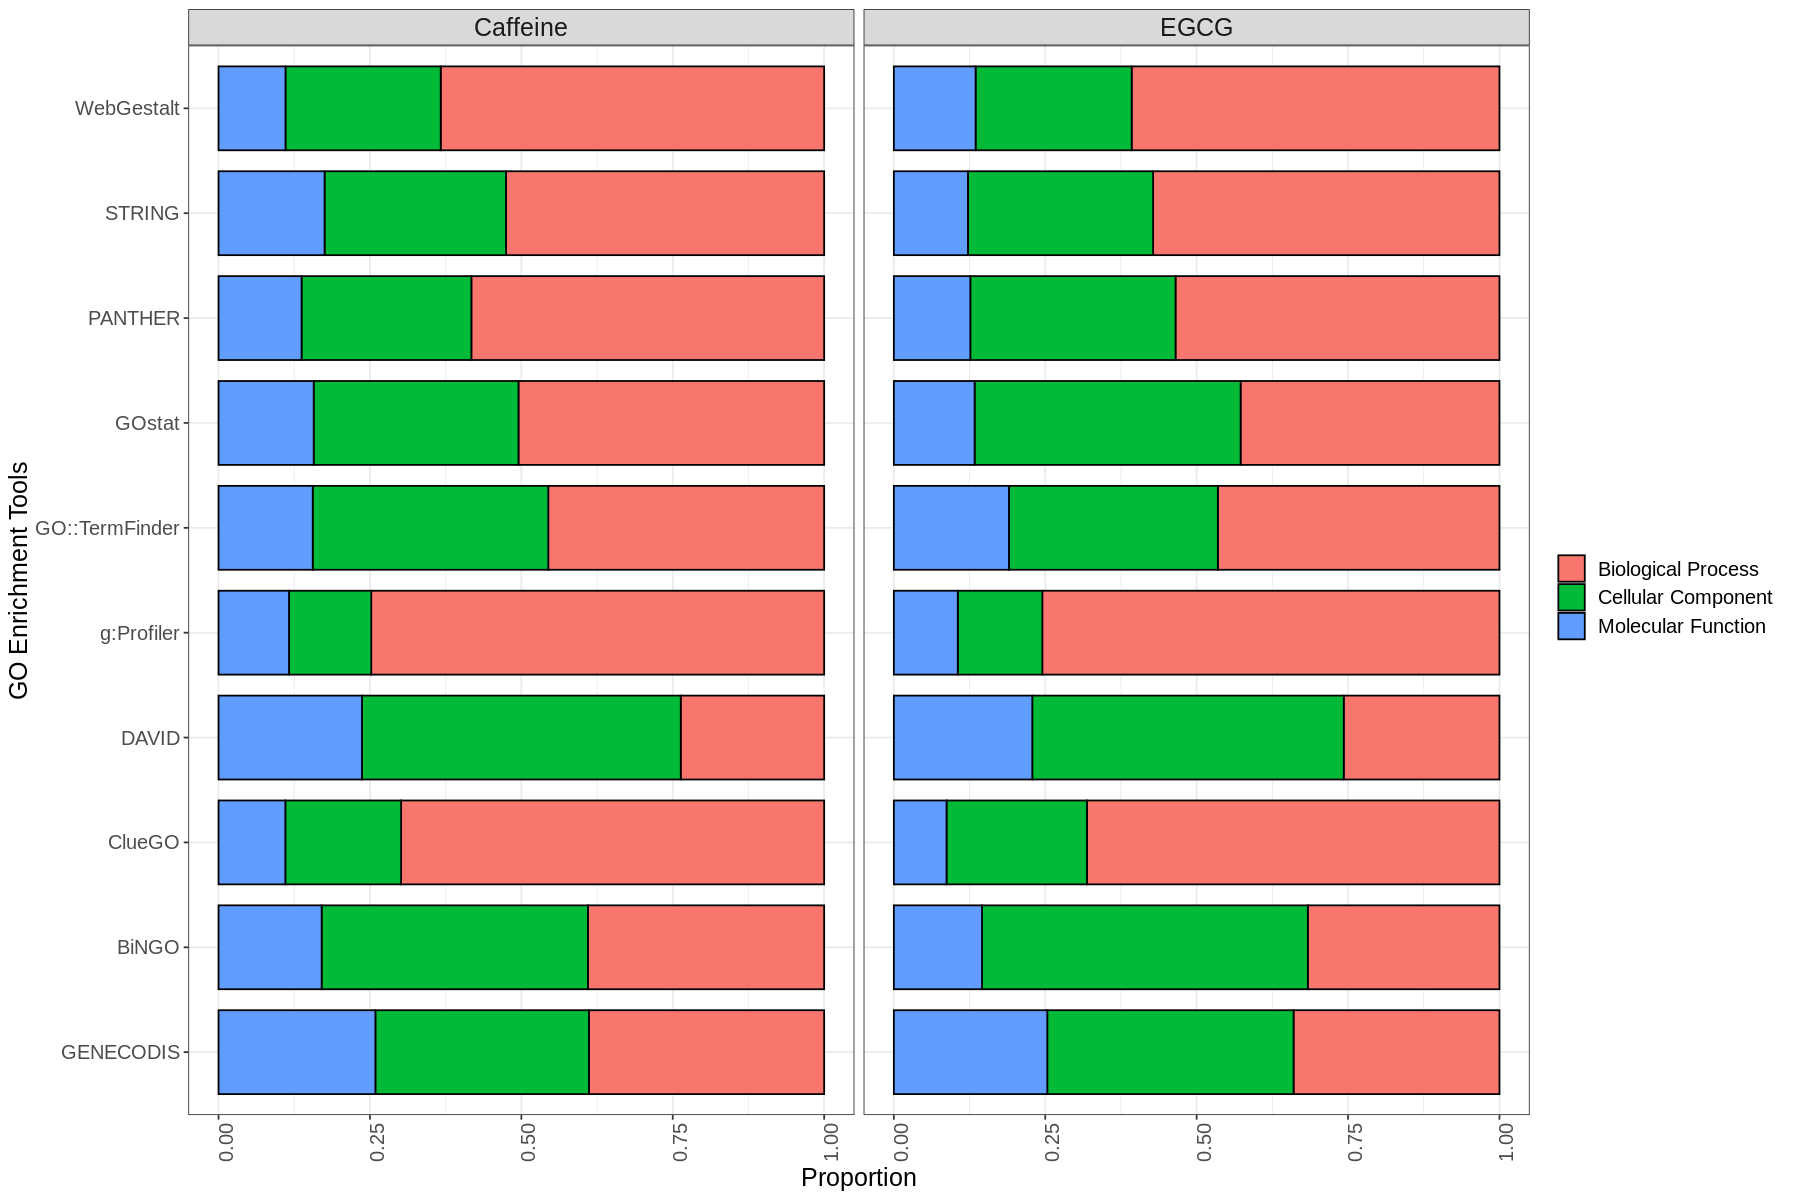

In [204]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data=chi_4, aes(x=reorder(Database,-value), y=value, fill=variable)) +
  geom_bar(stat="identity",color = "black",width=0.8) +
  theme_bw() + ylab("Proportion") + xlab("GO Enrichment Tools")  + guides(fill=guide_legend(title="")) + 
  coord_flip()+
  facet_grid(. ~ Dataset) + 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1)) +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                            "Cellular Component",
                                            "Molecular Function"))

## Chi-square Test

### Test between and within group

In [246]:
# Chitest between

for (i in unique(chi_03$Database) %>% unlist()) {
  print(i)
  chi_05 <- chi_03 %>% filter(.,Database == i) %>% dplyr::select(-Dataset)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)
  print(x)
}

[1] "BiNGO"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 2.9008, df = 2, p-value = 0.2345

[1] "ClueGO"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 0.63356, df = 2, p-value = 0.7285

[1] "DAVID"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 0.040868, df = 2, p-value = 0.9798

[1] "g:Profiler"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 1.4, df = 2, p-value = 0.4966

[1] "GENECODIS"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 1.0317, df = 2, p-value = 0.597

[1] "GO::TermFinder"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 1.1644, df = 2, p-value = 0.5587

[1] "GOstat"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 4.9339, df = 2, p-value = 0.08484

[1] "PANTHER"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 2.491, df = 2, p-value = 0.2878

[1] "STRING"

	Pearson's Chi-squared test

data:  chi_06
X-squared = 3.0663, df = 2, p-value = 0.2159

[1] "WebGestalt"

	Pearson's Chi-squared test

data:  chi_06

In [ ]:
# Chitest within
for (i in unique(chi_03$Dataset) %>% unlist()) {
  print(i)
  chi_05 <- chi_03 %>% filter(.,Dataset == i) %>% dplyr::select(-Database)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)  
  print(x$statistic)
  print(x$p.value)}



[1] "Caffeine"
X-squared 
 296.1834 
[1] 2.932644e-52
[1] "EGCG"


Warning message in chisq.test(chi_06):
“Chi-squared approximation may be incorrect”


X-squared 
 468.8059 
[1] 3.709202e-88


In [ ]:
#pairwise (Within Group)
for (i in unique(chi_03$Dataset) %>% unlist()) {
  print(i)
  chi_05 <- chi_03 %>% filter(.,Dataset == i) %>% dplyr::select(-Dataset)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)  
  print(x$statistic)
  print(x$p.value)}


[1] "Caffeine"
X-squared 
 296.1834 
[1] 2.932644e-52
[1] "EGCG"


Warning message in chisq.test(chi_06):
“Chi-squared approximation may be incorrect”


X-squared 
 468.8059 
[1] 3.709202e-88


### Heatmap For Pairwise Comparison

#### EGCG dataset

In [ ]:

x.01 <- chi_03 %>% filter(.,Dataset != "Caffeine") %>% dplyr::select(-Dataset)
x.02 <- t(x.01[,-1]) %>% as.data.frame
df_name <- x.01[1] %>% unlist()
names(x.02) <- df_name
chi_03
x.02

,Database,Dataset,BP,CC,MF
,<fct>,<fct>,<int>,<int>,<int>
1,BiNGO,Caffeine,55,62,24
2,ClueGO,Caffeine,95,26,15
3,DAVID,Caffeine,9,20,9
4,g:Profiler,Caffeine,1427,259,222
5,GENECODIS,Caffeine,54,49,36
6,GO::TermFinder,Caffeine,82,70,28
7,GOstat,Caffeine,106,71,33
8,PANTHER,Caffeine,187,90,44
9,STRING,Caffeine,135,77,45


,BiNGO,ClueGO,DAVID,g:Profiler,GENECODIS,GO::TermFinder,GOstat,PANTHER,STRING,WebGestalt
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BP,50,47,9,2082,51,93,109,161,159,99
CC,85,16,18,385,61,69,112,102,85,42
MF,23,6,8,291,38,38,34,38,34,22


In [ ]:
# initialization
out_list <- list()
column <- 1
# cycle for storing kappa2's output structure
for (i in 1:(ncol(x.02)-1)){
  for (j in (i+1):ncol(x.02)){
    x <- chisq.test(x.02[,c(i,j)])
    out_list[[column]] <- x$p.value
    # renaming the elements
    names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
    column <- column + 1
  }
}

res.eg <- do.call(rbind,out_list) %>% as.data.frame()
res.eg$data <- rownames(res.eg)
res.eg.1 <- splitstackshape::cSplit(res.eg, "data", "_")
res.eg.1$type <- "EGCG Dataset"

res.eg.1


#### Caffeine dataset

In [ ]:
x.01 <- chi_03 %>% filter(.,Dataset != "EGCG") %>% dplyr::select(-Dataset)
x.02 <- t(x.01[,-1]) %>% as.data.frame
df_name <- x.01[1] %>% unlist()
names(x.02) <- df_name


In [ ]:
# initialization
out_list <- list()
column <- 1
# cycle for storing kappa2's output structure
for (i in 1:(ncol(x.02)-1)){
  for (j in (i+1):ncol(x.02)){
    x <- chisq.test(x.02[,c(i,j)])
    out_list[[column]] <- x$p.value
    # renaming the elements
    names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
    column <- column + 1
  }
}

res.caf <- do.call(rbind,out_list) %>% as.data.frame()
res.caf$data <- rownames(res.caf)
res.caf.1 <- splitstackshape::cSplit(res.caf, "data", "_")
res.caf.1$type <- "Caffeine Dataset"



Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”


In [ ]:
res.all <- rbind(res.caf.1,res.eg.1)
res.all$data_2 <- gsub(".[0-9]", "", res.all$data_2)

res.all$sig <- ifelse(res.all$V1 < 0.001,"***",
                      ifelse(res.all$V1 < 0.01,"**",
                             ifelse(res.all$V1 < 0.05,"*","ns")))


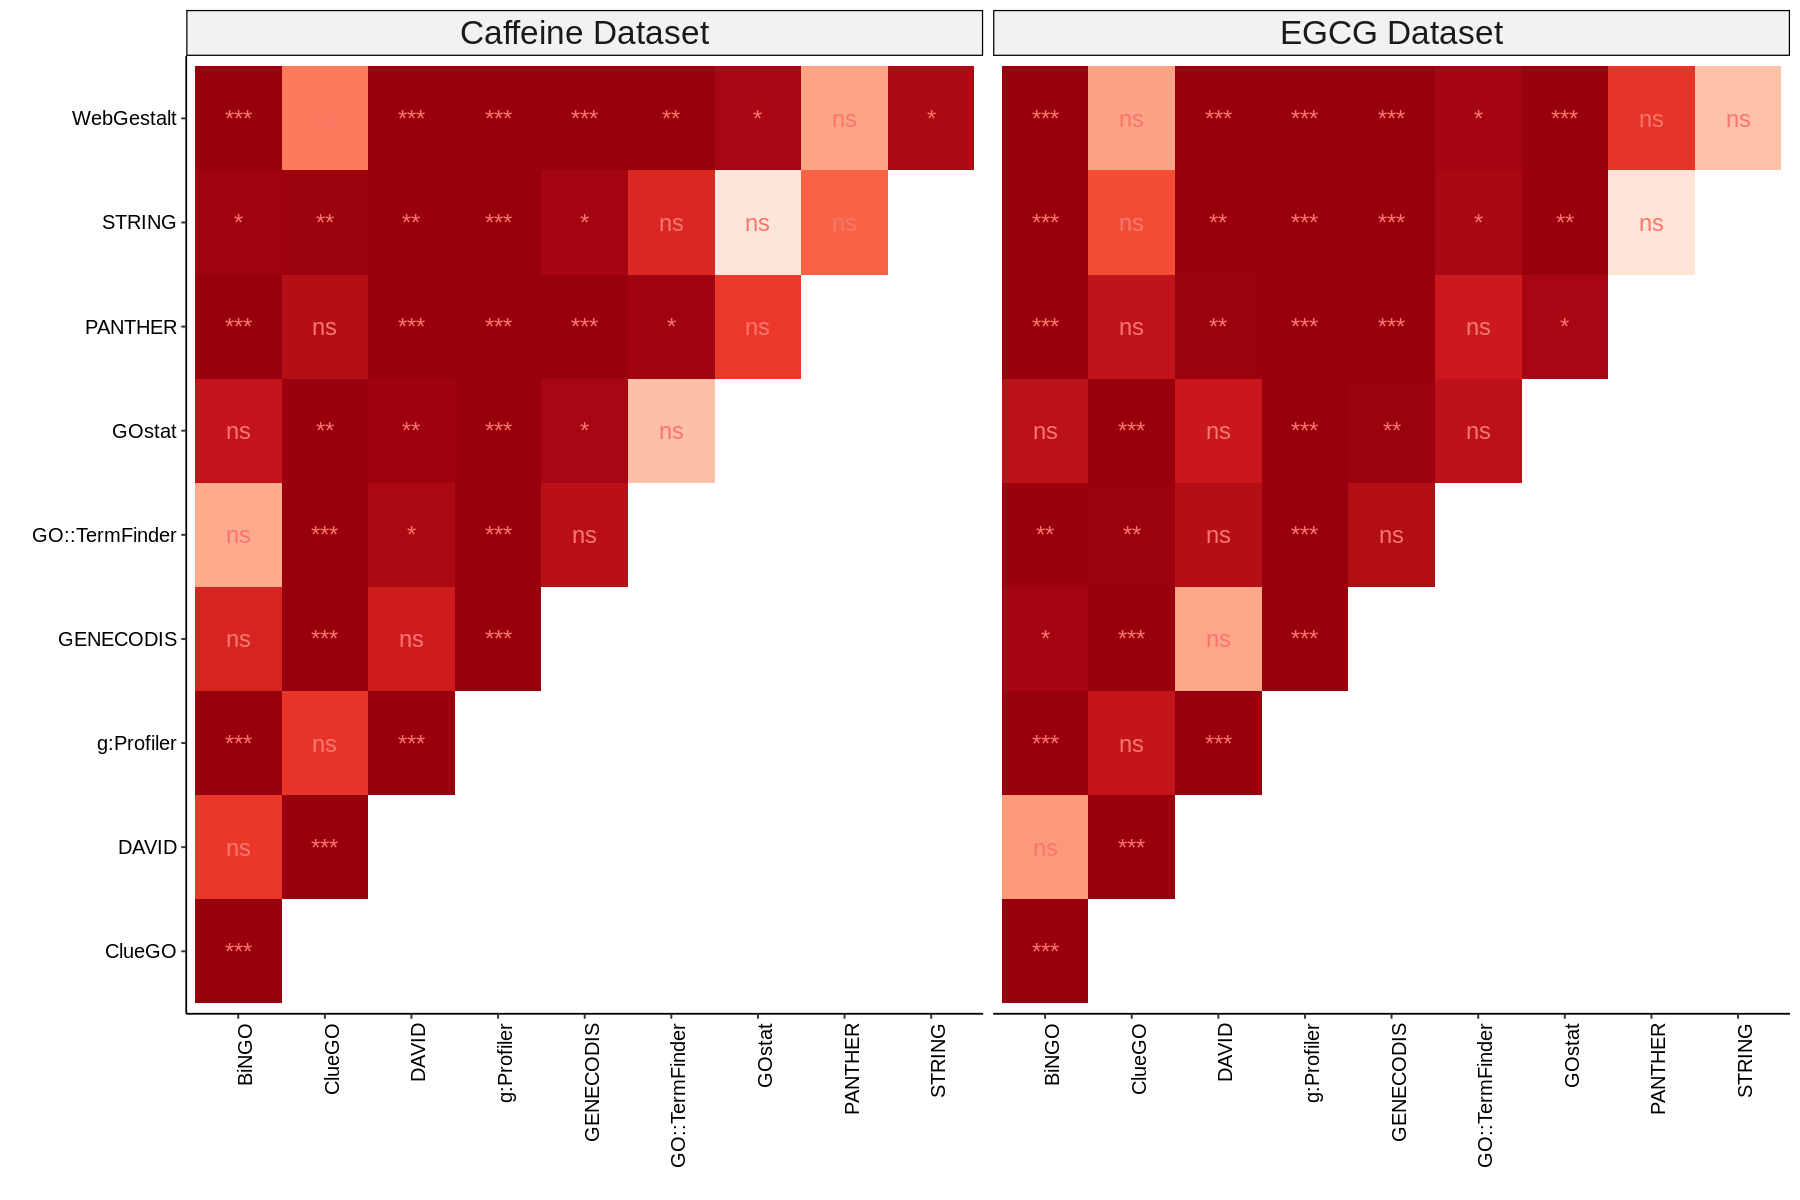

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data = res.all, aes(x = data_1, y = data_2)) +
  geom_tile(aes(fill=V1))+
  facet_grid(cols=vars(type)) + 
  theme_pubr() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  geom_text(aes(label=sig,color="white"),cex=5)+
  theme(legend.position="none") +
  scale_fill_distiller(palette = "Reds") +
  xlab("") +
  ylab("") + 
  theme(strip.text.x = element_text(size = 20)) 

# **The comparison of the number of annotated gene**

In [ ]:
df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
setnames("Group","Dataset")
all <- df %>% filter(.,Enrichment == "All (Up vs. Down)")
all$Condition <- ifelse(all$FDR < 0.05,"Significant","Unsignificant")
head(all)

GOID,Description,FDR,Database,Type,Genes,Enrichment,Dataset,Condition
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBAL3,All (Up vs. Down),EGCG,Unsignificant
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,ACTL6B,All (Up vs. Down),EGCG,Unsignificant
GO:0007010,cytoskeleton organization,0.894,DAVID,BP,TUBB6,All (Up vs. Down),EGCG,Unsignificant
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,CAV1,All (Up vs. Down),EGCG,Unsignificant
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMC4,All (Up vs. Down),EGCG,Unsignificant
GO:0090090,negative regulation of canonical Wnt signaling pathway,0.885,DAVID,BP,PSMA5,All (Up vs. Down),EGCG,Unsignificant


##EGCG

In [ ]:
gene_duplicate <- all %>% filter(Dataset == "EGCG") %>%  
  dplyr::select(GOID,Database,Dataset) %>% unique()
#dup = 486
gene_duplicate.list <- table(gene_duplicate$GOID) %>% as.data.frame() %>% filter(.,Freq > 1) %>% dplyr::select(Var1) %>% unlist() 
head(gene_duplicate.list)
# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) 

# dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) 


# equal = 127
Tgene_equal <- Tgene_max$count - Tgene_min$count %>% as.data.frame()
Tgene_equal$GOID <- Tgene_max$GOID
names(Tgene_equal) <- c("range","GOID")
equal_gene <- Tgene_equal %>% filter(.,range == 0) %>% dplyr::select(GOID) %>% unlist()


# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)  

 dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)



count.max <- table(Tgene_max$Database,Tgene_max$Dataset,Tgene_max$Type) %>% as.data.frame()
count.max$con <- "Maximum"
count.min <- table(Tgene_min$Database,Tgene_min$Dataset,Tgene_min$Type) %>% as.data.frame()
count.min$con <- "Minimum" 

min_max.EGCG <- rbind(count.max,count.min)

head(min_max.EGCG)


Var11      Var12      Var13      Var14      Var15      Var16 
GO:0000028 GO:0000122 GO:0000166 GO:0000184 GO:0000278 GO:0000398 
2191 Levels: GO:0000003 GO:0000018 GO:0000028 GO:0000049 ... GO:2001252

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)



,Var1,Var2,Var3,Freq,con
,<fct>,<fct>,<fct>,<int>,<chr>
1,BiNGO,EGCG,BP,2,Maximum
2,ClueGO,EGCG,BP,11,Maximum
3,DAVID,EGCG,BP,1,Maximum
4,g:Profiler,EGCG,BP,170,Maximum
5,GO::TermFinder,EGCG,BP,8,Maximum
6,GOstat,EGCG,BP,3,Maximum


##Caffeine

In [ ]:
gene_duplicate <- all %>% filter(Dataset == "Caffeine") %>%  
  dplyr::select(GOID,Database,Dataset) %>% unique()

#dup = 486
gene_duplicate.list <- table(gene_duplicate$GOID) %>% as.data.frame() %>% filter(.,Freq > 1) %>% dplyr::select(Var1) %>% unlist() 

# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) 

# dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) 


# equal = 127
Tgene_equal <- Tgene_max$count - Tgene_min$count %>% as.data.frame()
Tgene_equal$GOID <- Tgene_max$GOID
names(Tgene_equal) <- c("range","GOID")
equal_gene <- Tgene_equal %>% filter(.,range == 0) %>% dplyr::select(GOID) %>% unlist()


# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.min(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)  

 dup.01 = 359
Tgene_max <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) %>% group_by(GOID)%>%
  dplyr::slice(which.max(count)) %>% as.data.frame() %>% filter(.,!GOID %in% equal_gene)



count.max <- table(Tgene_max$Database,Tgene_max$Dataset,Tgene_max$Type) %>% as.data.frame()
count.max$con <- "Maximum"
count.min <- table(Tgene_min$Database,Tgene_min$Dataset,Tgene_min$Type) %>% as.data.frame()
count.min$con <- "Minimum" 

min_max.Caffeine <- rbind(count.max,count.min)
head(min_max.Caffeine)


`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)



,Var1,Var2,Var3,Freq,con
,<fct>,<fct>,<fct>,<int>,<chr>
1,BiNGO,Caffeine,BP,3,Maximum
2,ClueGO,Caffeine,BP,39,Maximum
3,DAVID,Caffeine,BP,1,Maximum
4,g:Profiler,Caffeine,BP,166,Maximum
5,GENECODIS,Caffeine,BP,0,Maximum
6,GO::TermFinder,Caffeine,BP,18,Maximum


## Combine dataframe and plot

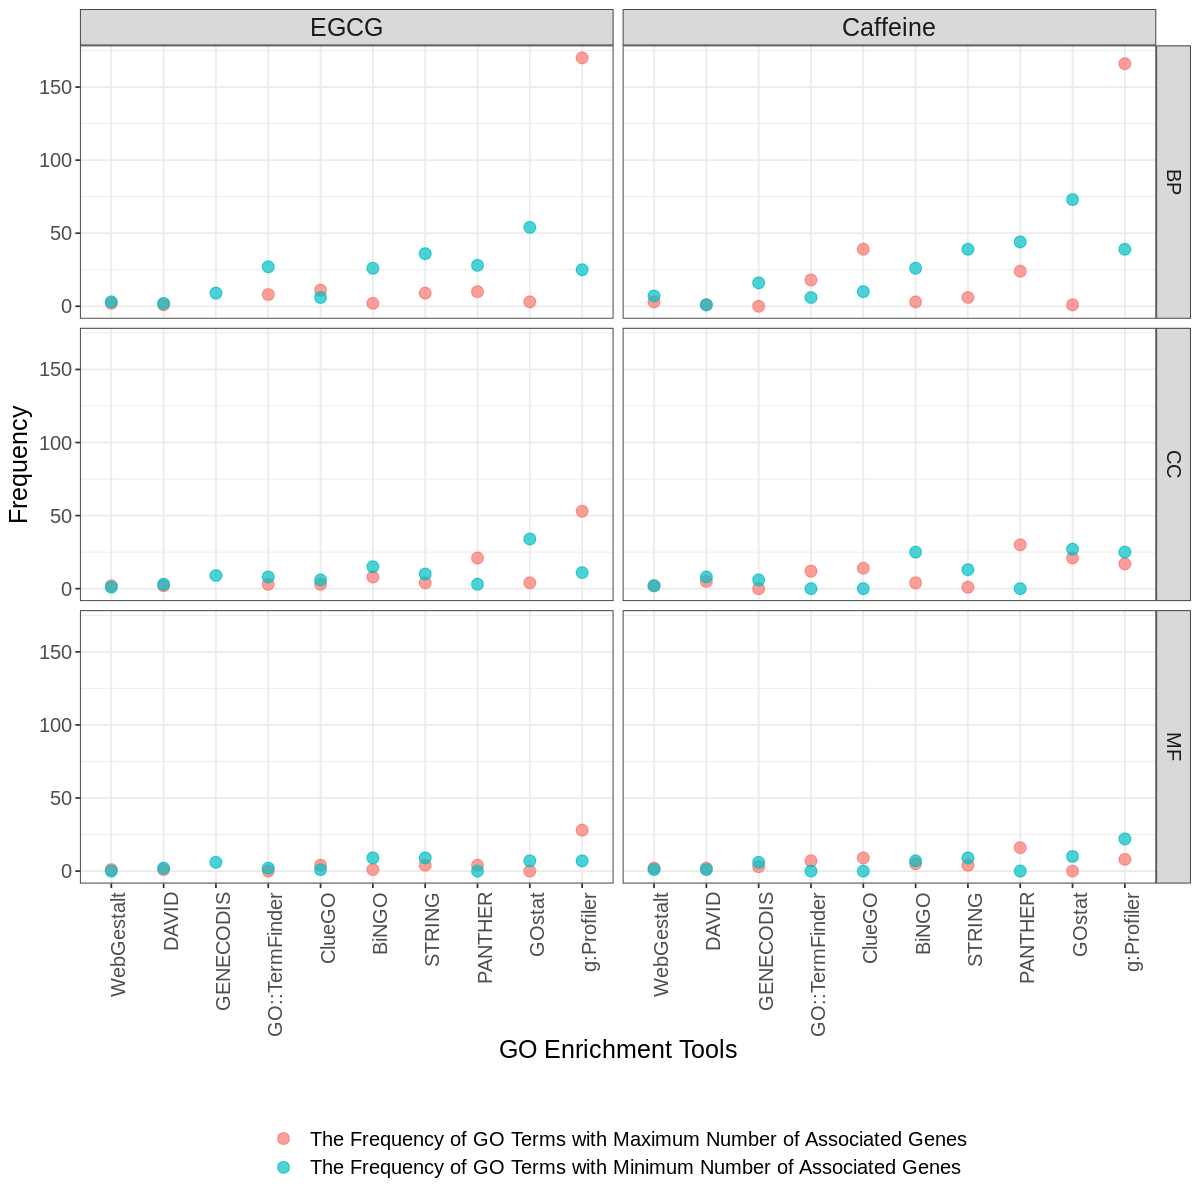

In [ ]:

min_max.all <- rbind(min_max.EGCG,min_max.Caffeine)  %>% group_by(Var2,Var3,con) %>%
  mutate(my_ranks = order(order(Freq, decreasing=TRUE)))

min_max.all$con_02 <- ifelse(min_max.all$con == "Maximum",
                             "The Frequency of GO Terms with Maximum Number of Associated Genes",
                             "The Frequency of GO Terms with Minimum Number of Associated Genes")
options(repr.plot.width=10, repr.plot.height=10)
ggplot(data=min_max.all, aes(x=reorder(Var1,Freq), y=Freq, color=con_02)) +
  geom_point(size = 3,alpha = 0.7) +
  theme_bw() +
  facet_grid(vars(Var3),vars(Var2)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(fill = "") +
  xlab("GO Enrichment Tools") +
  ylab("Frequency") +
  labs(color="") +
  theme(legend.position="bottom", legend.direction="vertical") + 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15),
        axis.text.x = element_text(angle=90, hjust=1))



## compare g:Profiler and BiNGO 

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'GOID', 'Type', 'Database' (override with `.groups` argument)



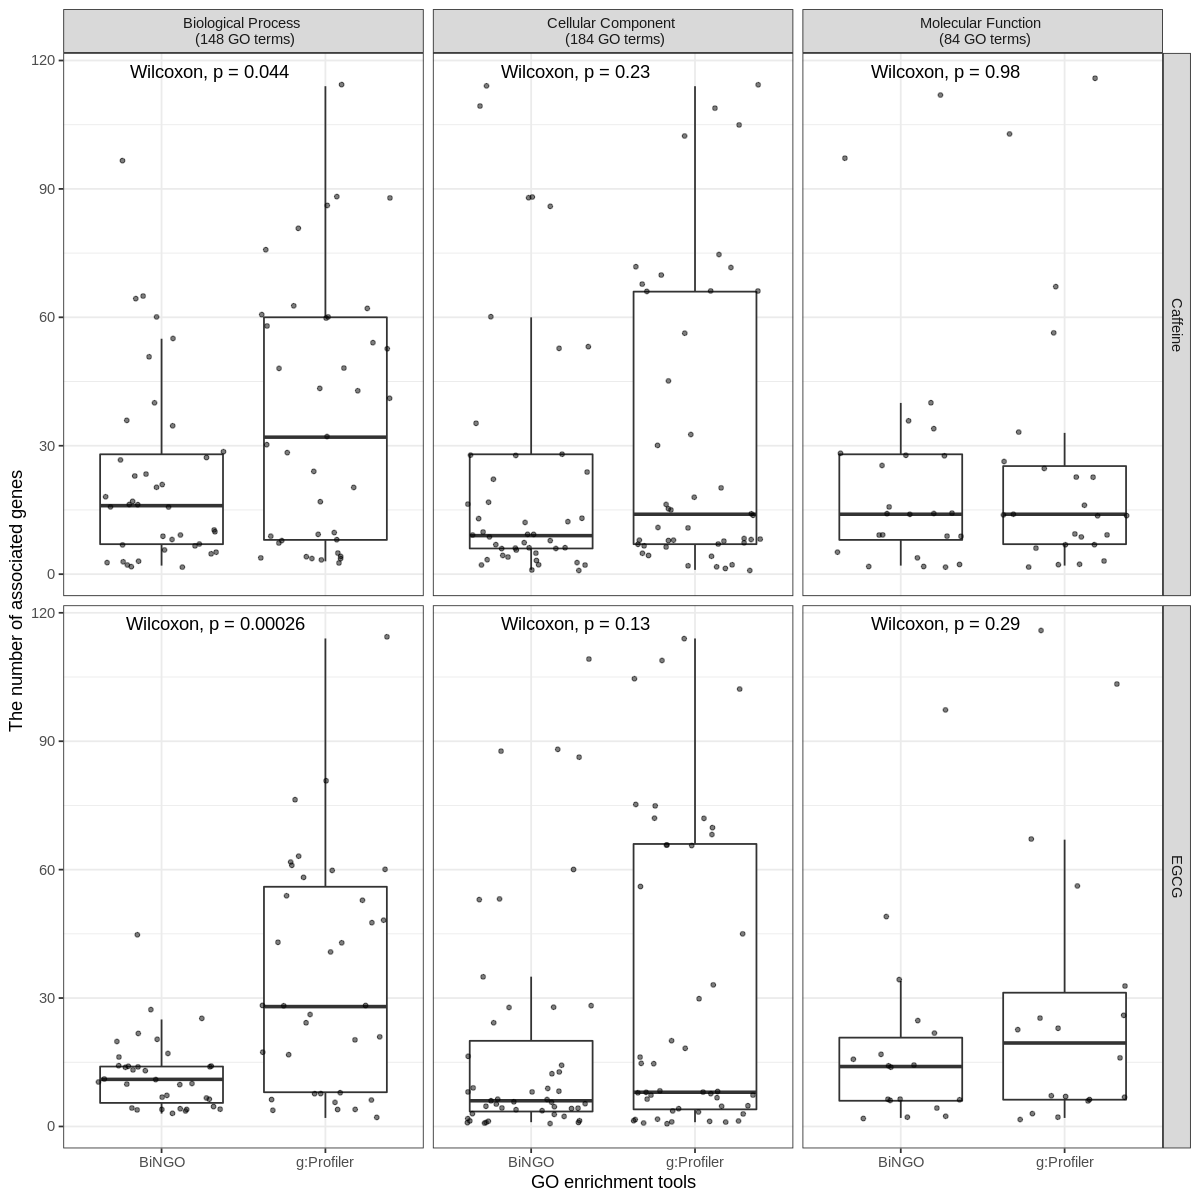

In [ ]:
#Caffeine
gene_duplicate <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>%  
  dplyr::select(GOID,Database,Dataset) %>% unique()
gene_duplicate.list <- table(gene_duplicate$GOID) %>% as.data.frame() %>% filter(.,Freq > 1) %>% dplyr::select(Var1) %>% unlist() 



Tgene_min.caf <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "Caffeine") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) 

#EGCG

gene_duplicate <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>%  
  dplyr::select(GOID,Database,Dataset) %>% unique()
#dup = 486
gene_duplicate.list <- table(gene_duplicate$GOID) %>% as.data.frame() %>% filter(.,Freq > 1) %>% dplyr::select(Var1) %>% unlist() 

# dup.01 = 359
Tgene_min <- all %>% filter(.,Condition == "Significant") %>% filter(.,Dataset == "EGCG") %>% 
  filter(.,GOID %in% gene_duplicate.list) %>% 
  group_by(GOID,Type,Database,Dataset) %>% dplyr::summarise(count=n()) 


sim_caf <- function(x,y){
    a.01 <- Tgene_min.caf[,-4] %>% filter(.,Database %in% c(x,y))
    a <- table(a.01$GOID) %>% as.data.frame() %>% filter(.,Freq == 2) %>% dplyr::select(Var1) %>% unlist()
    a.02 <- a.01 %>% filter(.,GOID %in% a)
}


gpro.01.caf <- sim_caf("g:Profiler","BiNGO")
gpro.01.caf$set <- "Caffeine"


sim <- function(x,y){
  a.01 <- Tgene_min[,-4] %>% filter(.,Database %in% c(x,y))
  a <- table(a.01$GOID) %>% as.data.frame() %>% filter(.,Freq == 2) %>% dplyr::select(Var1) %>% unlist()
  a.02 <- a.01 %>% filter(.,GOID %in% a)
}

gpro.01 <- sim("g:Profiler","BiNGO")
gpro.01$set <- "EGCG"

all.c <- rbind(gpro.01,gpro.01.caf)
all.c$Type <- as.factor(all.c$Type)
levels(all.c$Type) <- c("Biological Process \n (148 GO terms)",
                        "Cellular Component \n (184 GO terms)",
                        "Molecular Function \n (84 GO terms)")
options(repr.plot.width=15, repr.plot.height=10)
ggplot(all.c, aes(x=reorder(Database,count), y=count)) + 
  geom_boxplot(outlier.shape = NA) +
  geom_jitter(alpha=0.5,size = 1) +
  facet_grid(vars(set),vars(Type)) +
  stat_compare_means() +
  theme_bw()  +
  xlab("GO enrichment tools") +
  ylab("The number of associated genes") 


##Test Correlation

`geom_smooth()` using formula 'y ~ x'



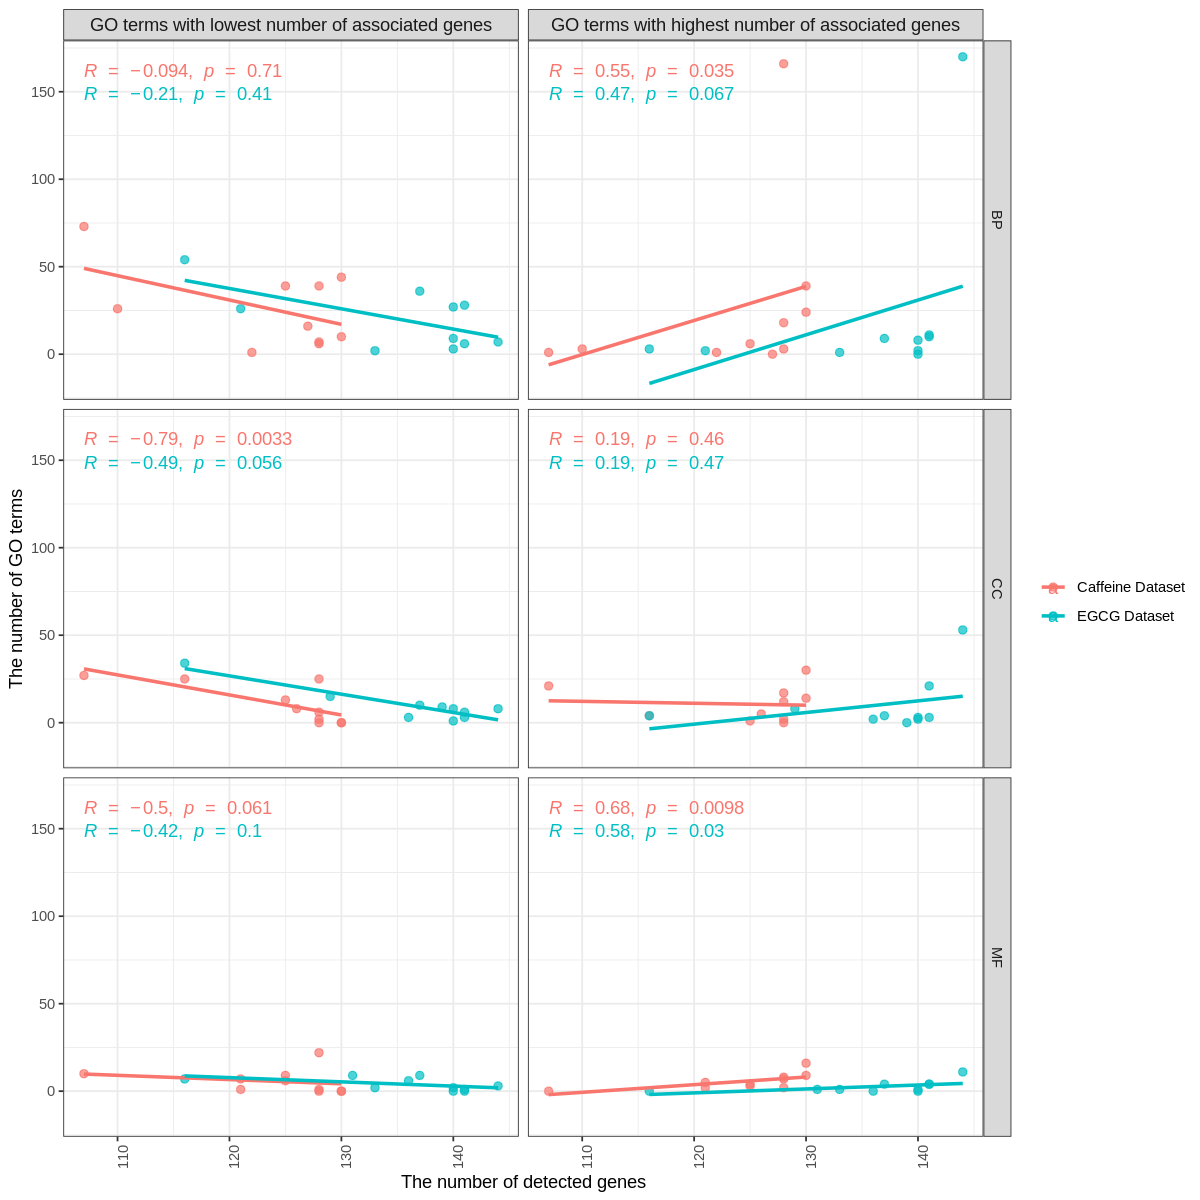

In [ ]:

df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Correlation-GOterm-Input.txt") %>% melt(.,id.vars=c("dataset","Input","Tools","Type"))

options(repr.plot.width=10, repr.plot.height=10)
ggplot(df,aes(x=Input,y=value, color=dataset)) +
  geom_point(size = 2,alpha = 0.7) +
  theme_bw() +
  facet_grid(vars(Type),vars(variable)) +
  stat_cor(method="kendall") +
  xlab("The number of detected genes") +
  ylab("The number of GO terms") +
  labs(color="") +
  geom_smooth(method='lm',se = FALSE) + 
  theme(strip.text.x = element_text(size = 11))+
  theme(text = element_text(size=11),
        axis.text.x = element_text(angle=90, hjust=1))



Warning message in melt.data.table(.):
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Database, con, Var3, ...]. Consider providing at least one of 'id' or 'measure' vars in future.”


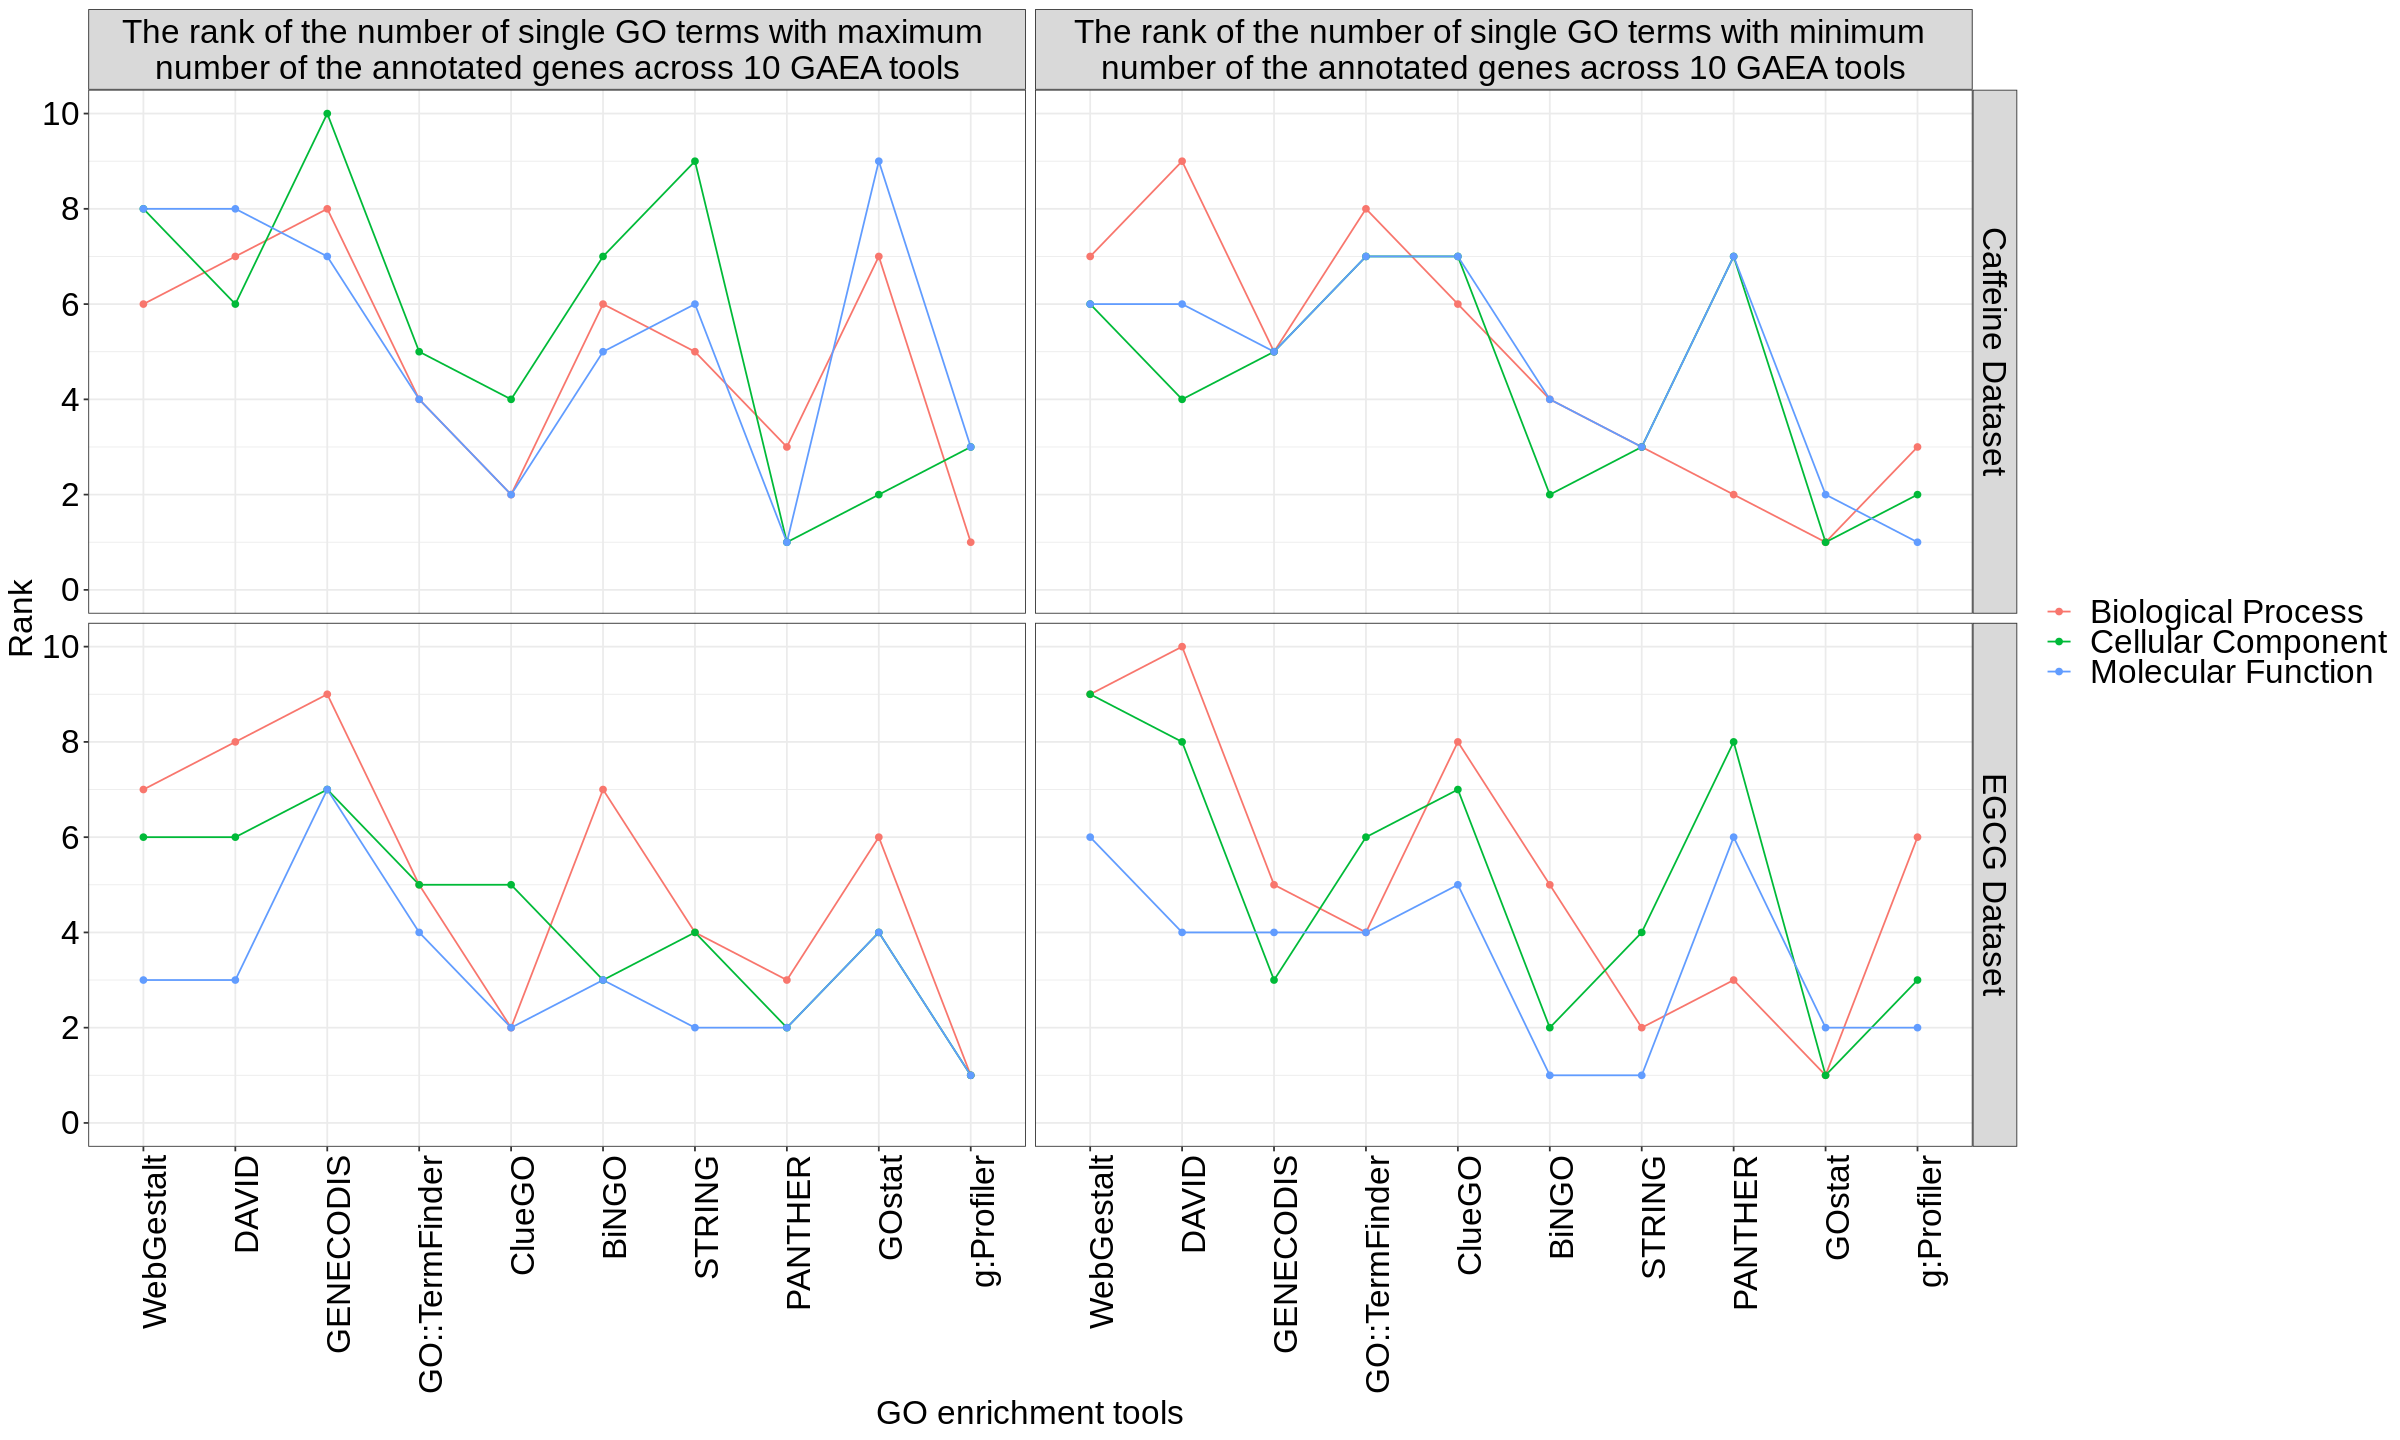

In [ ]:
options(repr.plot.width=20, repr.plot.height=12)
names <- c(`Maximum` = "The rank of the number of single GO terms with maximum \nnumber of the annotated genes across 10 GAEA tools",
           `Minimum` = "The rank of the number of single GO terms with minimum \nnumber of the annotated genes across 10 GAEA tools",
           my_ranks_caf = "Caffeine Dataset",
           my_ranks_egcg = "EGCG Dataset"
                    )

all.max <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Annotated_protein.csv")
df2 <- all.max[,-c(4,6,8)] %>% melt()
ggplot(data=df2, aes(x=reorder(Database,-value), y=value,group=Var3)) +
  geom_line(aes(color=Var3))+
  geom_point(aes(color=Var3)) +
  theme_bw() +
  facet_grid(cols=vars(con),rows=vars(variable),labeller = as_labeller(names))+
  theme(axis.text.y   = element_text(size=20,family = 'Arial',color="black"),
        axis.text.x = element_text(size = 20,angle = 90, hjust = 1,family = 'Arial',color="black"),
        axis.title.y  = element_text(size=20,family = 'Arial',color="black"),
        axis.title.x  = element_text(size=20,family = 'Arial',color="black"),
        strip.text.x = element_text(size = 20,family = 'Arial',color="black"),
        strip.text.y = element_text(size = 20,family = 'Arial',color="black")) +
  theme(legend.title=element_text(size=20), 
        legend.text=element_text(size=20))+ 
        xlab("GO enrichment tools") +
        ylab("Rank") +
        scale_y_continuous(breaks=seq(0, 10, 2), limits=c(0, 10))+
        labs(color="") + 
        scale_color_manual(labels = c("Biological Process", "Cellular Component","Molecular Function"), values = c("#F8766D","#00BA38","#619CFF"))



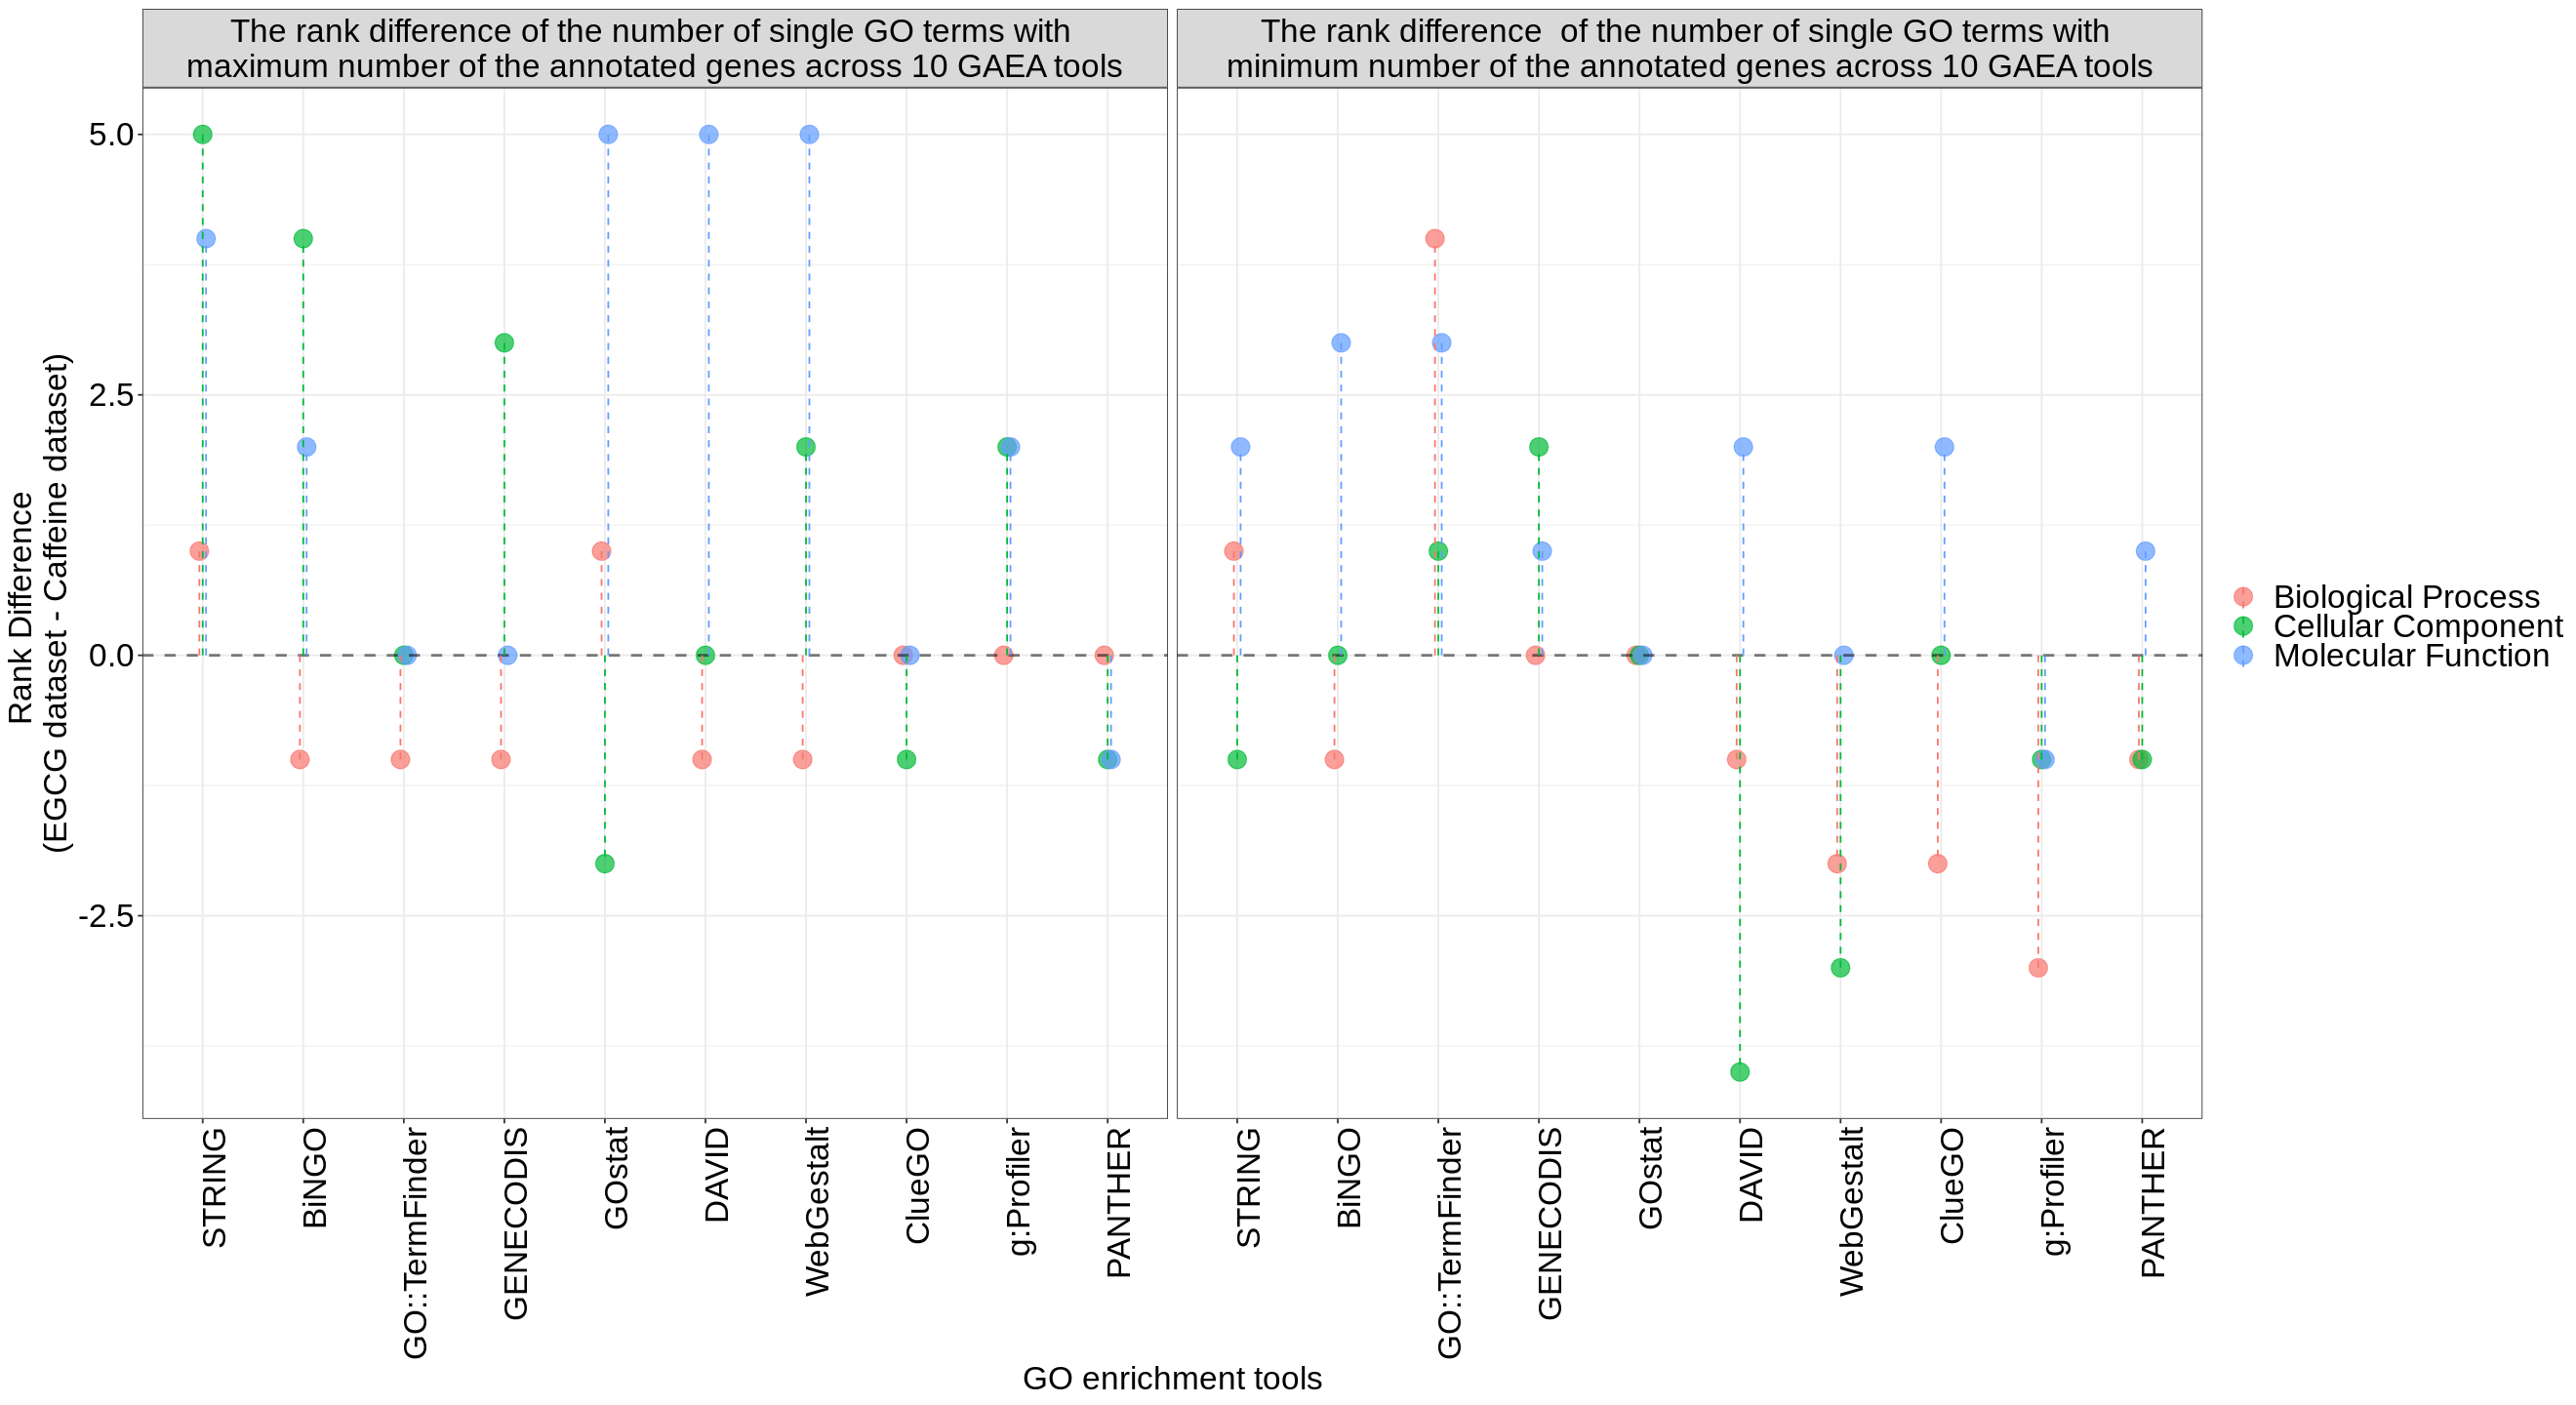

In [ ]:
options(repr.plot.width=22, repr.plot.height=12)
names <- c(`Maximum` = "The rank difference of the number of single GO terms with \nmaximum number of the annotated genes across 10 GAEA tools",
           `Minimum` = "The rank difference  of the number of single GO terms with \nminimum number of the annotated genes across 10 GAEA tools"
                    )

ggplot(data=all.max, aes(x=reorder(Database,-Range), y=Range,color=Var3)) +
  geom_point(aes(color=Var3),size = 5,alpha = 0.7, position=position_dodge(width=0.1))+ 
  theme_bw() +
  facet_grid(cols=vars(con), labeller = as_labeller(names))+
  xlab("GO enrichment tools") +
  ylab("Rank Difference \n(EGCG dataset - Caffeine dataset)") +
  labs(color="") + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ 
  theme(strip.text.x = element_text(size = 20))+
  theme(text = element_text(size=20))+
  geom_hline(yintercept=0, linetype="dashed", color = "black",size=0.8,alpha = 0.5) +
  geom_linerange(aes(x=Database,ymax=Range, ymin=0),
                 linetype = "dashed",
                 size = 0.5,
                 position = position_dodge(width=0.1))+
  theme(axis.text.y   = element_text(size=20,family = 'Arial',color="black"),
        axis.text.x = element_text(size = 20, hjust=1,family = 'Arial',color="black"),
        axis.title.y  = element_text(size=20,family = 'Arial',color="black"),
        axis.title.x  = element_text(size=20,family = 'Arial',color="black"),
        strip.text.x = element_text(size = 20,family = 'Arial',color="black"),
        strip.text.y = element_text(size = 20,family = 'Arial',color="black")) +
  theme(legend.title=element_text(size=20), 
        legend.text=element_text(size=20)) + 
        scale_color_manual(labels = c("Biological Process", "Cellular Component","Molecular Function"), values = c("#F8766D","#00BA38","#619CFF"))

# **The comparison of common vs. unique identified GO terms in the current and previous study**







## PCA

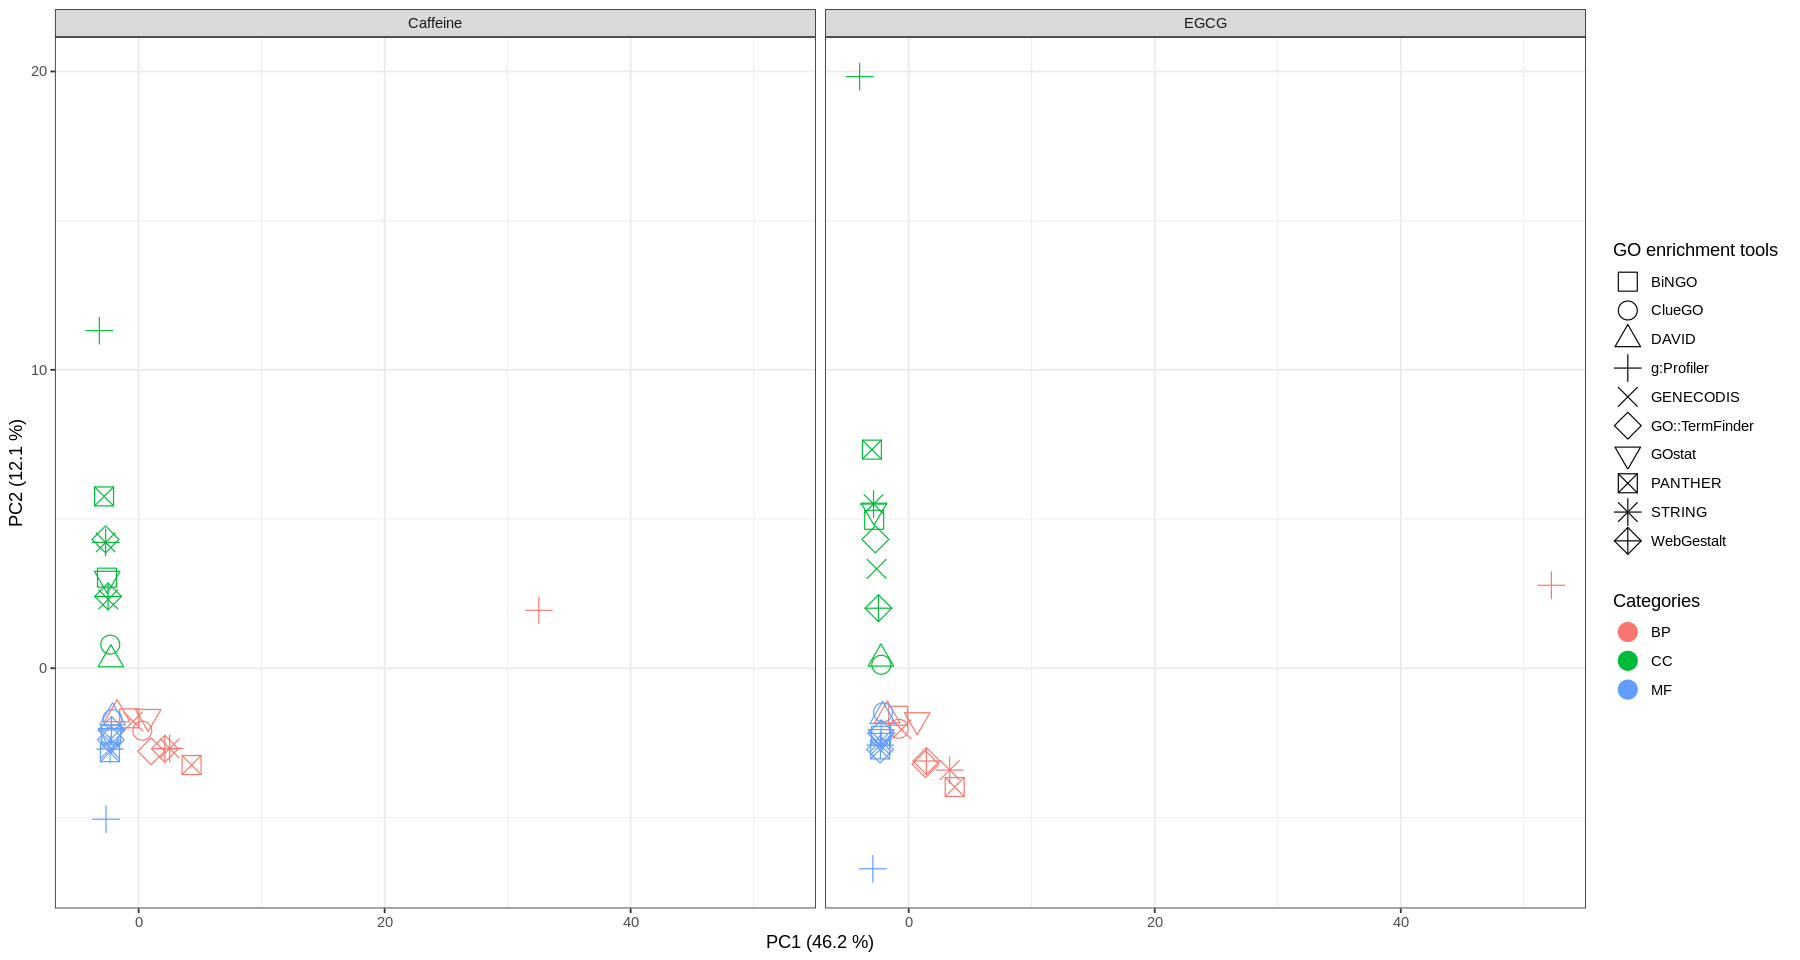

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-Genes) %>% unique() %>% filter(.,FDR < 0.05) %>% filter(.,Enrichment == "All (Up vs. Down)") %>% setnames("Group","Dataset")
pca_new_02 <- table(pca_new$Database,pca_new$GOID,pca_new$Dataset,pca_new$Type) %>% as.data.frame()
pca_new_03 <- reshape(pca_new_02, idvar = c("Var1","Var3","Var4"), timevar = "Var2", direction = "wide")
pca_new_04 <- pca_new_03[,-c(1,2,3)]

res.pca <- prcomp(pca_new_04)
#fviz_eig(res.pca,addlabels = TRUE)

ind <- res.pca$x %>% as.data.frame()
final_pca <- cbind(pca_new_03[,c(1:3)],ind) %>% setnames(c("Var1","Var3","Var4"),
                                                         c("GO enrichment tools","Datasets","Categories")) %>% as.data.frame()

options(repr.plot.width=15, repr.plot.height=8)
ggplot(final_pca, aes(x=PC1, y=PC2,
                      shape = `GO enrichment tools`,
                      color=Categories)) +
  geom_point(size = 5) +
  theme_classic(base_size = 12)   +
  theme_bw() + xlab("PC1 (46.2 %)") +ylab("PC2 (12.1 %)") +
  scale_shape_manual(values=seq(0,15)) +
  facet_grid(cols=vars(Datasets))

In [ ]:
Kappa_between <- function(database,categories){
  chi <- pca_new_03 %>% filter(Var3 == database, Var4 == categories) %>% select(-Var3,-Var4) 
  chi.01 <- chi[,-1]
  rownames(chi.01) <- chi[,1]
  chi.01[chi.01 > 1]<-1
  ex <-  chi.01 %>% t() %>% as.data.frame()
  out <- as.data.frame(matrix(0, nrow = 1, ncol = ncol(ex) * (ncol(ex)-1) / 2))
  column <- 1

  # cycle for calculation kappa
for (i in 1:(ncol(ex)-1)){
  for (j in (i+1):ncol(ex)){
    out[1,column] <- irr::kappa2(ex[,c(i,j)])$value
    colnames(out)[column] <- paste(colnames(ex[i]), 
                                      "&", colnames(ex[j]))
    column <- column + 1
  }
}
res <- t(out) %>% as.data.frame() 
res$categories <- categories
res$databases <- database
res
}


In [ ]:
EGCG.BP <- Kappa_between("EGCG","BP")
EGCG.MF <- Kappa_between("EGCG","MF")
EGCG.CC <- Kappa_between("EGCG","CC")

Caf.BP <- Kappa_between("Caffeine","BP")
Caf.MF <- Kappa_between("Caffeine","MF")
Caf.CC <- Kappa_between("Caffeine","CC")

cdf_EGCG_validate <- rbind(EGCG.BP,EGCG.MF,EGCG.CC)
cdf_caffeine_validate <- rbind(Caf.BP,Caf.MF,Caf.CC)
cdf_validate <- cbind(cdf_EGCG_validate,cdf_caffeine_validate)
cdf_validate.02 <- cdf_validate[,-c(2,3,6)] 
names(cdf_validate.02) <- c("EGCG","Caffeine","Categories")
print(cdf_validate.02)

### Variation Within Dataset

In [ ]:
cdf_validate.02$con_02 <- ifelse(cdf_validate.02$Caffeine < 0.2 & cdf_validate.02$EGCG < 0.2,"Difference","Not difference")
head(cdf_validate.02%>% melt())
names <- c(`BP` = "Biological Process",
           `CC` = "Cellular Component",
           MF="Molecular Function",
           Caffeine = "Caffeine Dataset",
           EGCG = "EGCG Dataset"
                    )


cdf_validate.02%>% melt() %>% 
  ggplot(aes(x=value)) +
  geom_histogram() +
  facet_grid(cols=vars(Categories),rows=vars(variable), labeller = as_labeller(names)) +
  geom_vline(xintercept=0.2, linetype="dashed", color = "red",size=1) +
  theme_bw() +
  xlab("Pair-wise Cohen's kappa coefficient (κ)")+
  ylab("Frequency")+
  theme(axis.text.y   = element_text(size=20,family = 'Arial',color="black"),
        axis.text.x = element_text(size = 20, vjust = 0.5, hjust=0.4,family = 'Arial',color="black"),
        axis.title.y  = element_text(size=20,family = 'Arial',color="black"),
        axis.title.x  = element_text(size=20,family = 'Arial',color="black"),
        strip.text.x = element_text(size = 20,family = 'Arial',color="black"),
        strip.text.y = element_text(size = 20,family = 'Arial',color="black")) +
  theme(legend.title=element_text(size=20), 
        legend.text=element_text(size=20))+ guides(color = FALSE)

### Variation Between Dataset

##### McNemar's Test

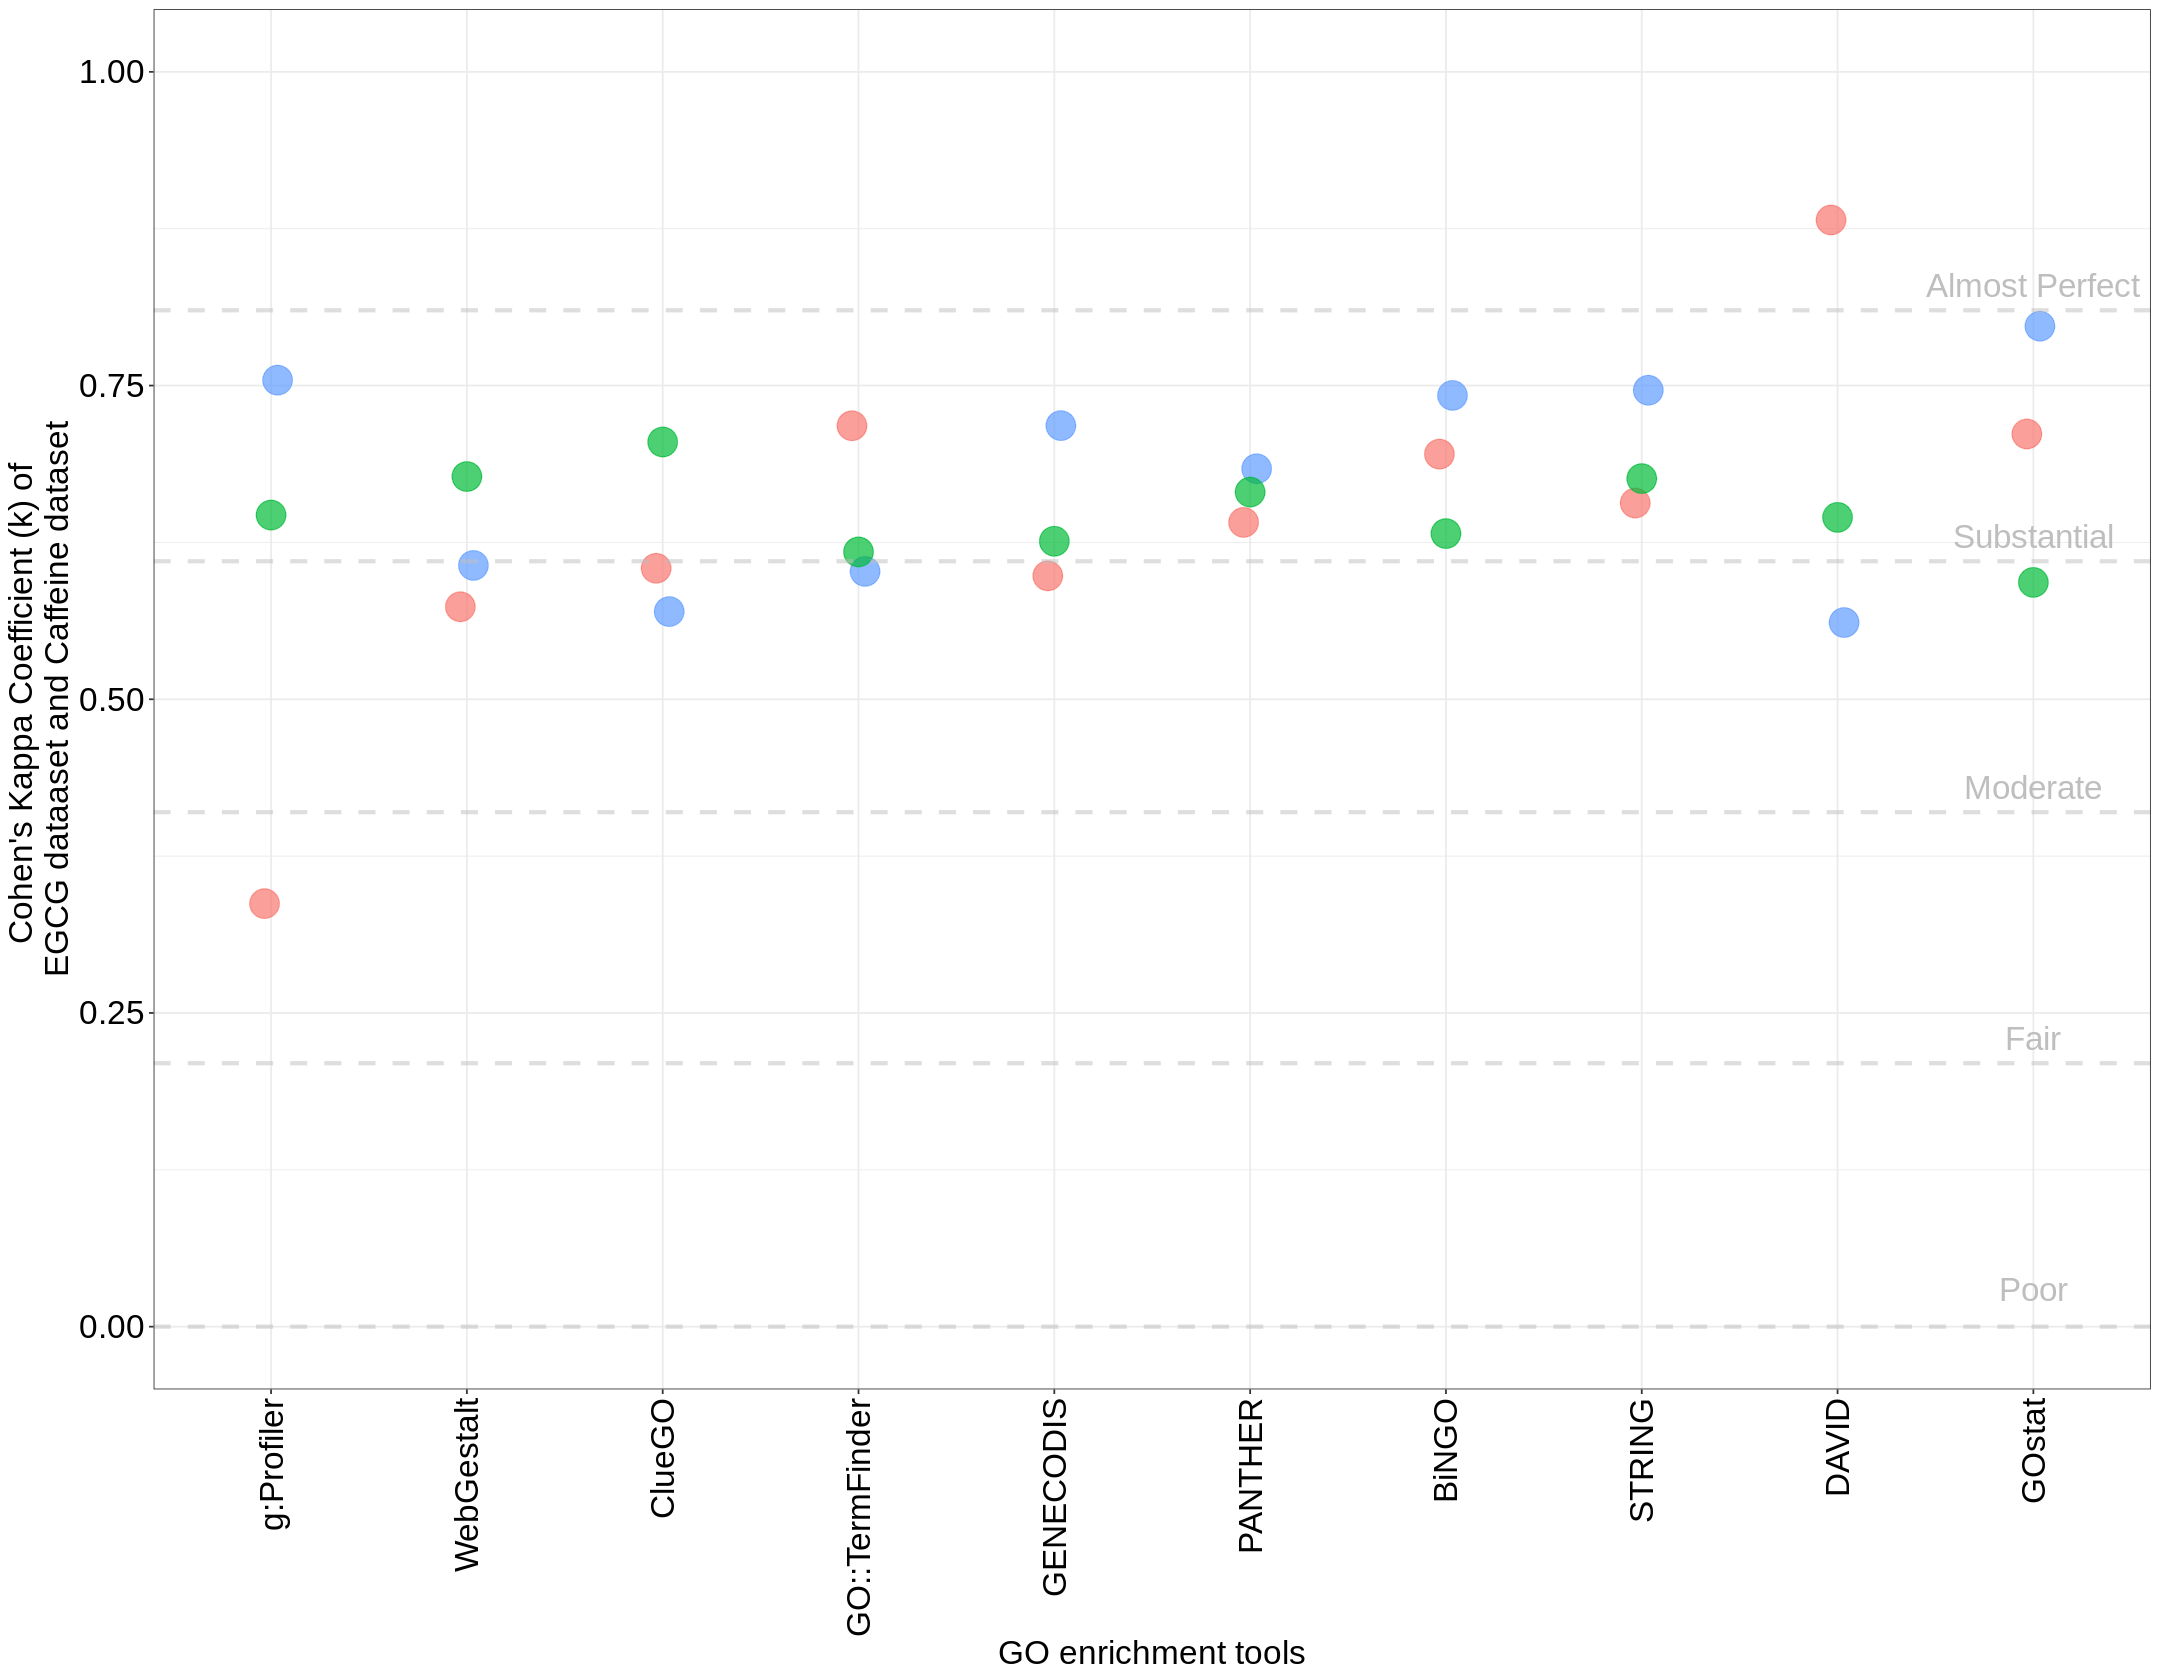

In [ ]:
pca.list <- pca_new_03[,1] %>% unique() %>% unlist()
cal_kap <- function(j){
  kap <- list()
  for(i in pca.list){
    chi <- pca_new_03 %>% filter(Var1 == i,Var4 == j) 
    chi.02 <- chi[,-c(1,2,3)] %>% t()
    chi.03 <- irr::kappa2((chi.02))$value %>% as.data.frame()
    chi.03$database <- i
    chi.03$categories <- j
    names(chi.03) <- c("kappa","database","categories")
    kap[[i]] <- chi.03
  } 
  big_data = do.call(rbind, kap)
}

big_data.BP <- cal_kap("BP")
big_data.MF <- cal_kap("MF")
big_data.CC <- cal_kap("CC")

all.kap <- rbind(big_data.BP,big_data.MF,big_data.CC)
ggplot(data=all.kap, aes(x=reorder(database,kappa), y=kappa,color=categories)) +
  geom_point(aes(color=categories),size = 8,alpha = 0.7, position=position_dodge(width=0.1))+ 
  theme_bw() +
  xlab("GO enrichment tools") +
  ylab("Cohen's Kappa Coefficient (k) of \nEGCG dataaset and Caffeine dataset") +
  theme(axis.text.y   = element_text(size=20,family = 'Arial',color="black"),
        axis.text.x = element_text(size = 20,angle = 90, vjust = 0.5, hjust=1,family = 'Arial',color="black"),
        axis.title.y  = element_text(size=20,family = 'Arial',color="black"),
        axis.title.x  = element_text(size=20,family = 'Arial',color="black"),
        strip.text.x = element_text(size = 20,family = 'Arial',color="black"),
        strip.text.y = element_text(size = 20,family = 'Arial',color="black")) +
  theme(legend.title=element_text(size=20), 
        legend.text=element_text(size=20))+ guides(color = FALSE)+
        ylim(0,1) + 
         geom_hline(yintercept=0.00, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.21, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.41, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.61, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.81, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         annotate(geom="text", x="GOstat", y=0.03, label="Poor",color="grey",size=7)+ 
         annotate(geom="text", x="GOstat", y=0.23, label="Fair",color="grey",size=7)+ 
         annotate(geom="text", x="GOstat", y=0.43, label="Moderate",color="grey",size=7)+ 
         annotate(geom="text", x="GOstat", y=0.63, label="Substantial",color="grey",size=7)+ 
         annotate(geom="text", x="GOstat", y=0.83, label="Almost Perfect",color="grey",size=7)









## Biological Perspective


In [ ]:
EGCG <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt")[,-2] %>% dplyr::select(-Genes) %>% unique() %>% 
filter(.,FDR < 0.05) %>% 
filter(.,Enrichment == "All (Up vs. Down)") %>% 
setnames("Group","Dataset") %>%
filter(.,Dataset == "EGCG")

Caffeine <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt")[,-2] %>% dplyr::select(-Genes) %>% unique() %>% 
filter(.,FDR < 0.05) %>% 
filter(.,Enrichment == "All (Up vs. Down)") %>% 
setnames("Group","Dataset") %>%
filter(.,Dataset == "Caffeine")

Previously <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Previously_found")[,-3] %>% setnames("evidence","Database")
Previously$Enrichment <- "All (Up vs. Down)"
cdf <- rbind(EGCG,Caffeine,Previously)
head(cdf)
ref <- "https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/GO_human.obo"

### Comparison among the present tools 

In [ ]:

gene_bin <- function(input){
  all.index <- input %>% dplyr::select(Database,Type,Enrichment,Dataset) %>% unique()
dat <- list()
for (i in 1:nrow(all.index)) {
  print(i)
  all.03 <- input %>% dplyr::filter(.,Type == all.index[i,2] %>% unlist(),
                                Database == all.index[i,1] %>% unlist(),
                                     Enrichment == all.index[i,3] %>% unlist(),
                                     Dataset == all.index[i,4]%>% unlist()) %>% 
    dplyr::select(GOID) %>% unlist()
  
  
  myCollection <- GOCollection(all.03)
  slim <- getOBOCollection(ref)
  
  res <- goSlim(myCollection, slim, all.index[i,2] %>% unlist()) %>% as.data.frame()
  res$id <- rownames(res)
  rownames(res) <- NULL
  
  res.1 <- res %>% filter(.,Count != 0)
  
  res.1$Type <- all.index[i,2] %>% unlist()
  res.1$Database <- all.index[i,1] %>% unlist()
  res.1$Enrichment <- all.index[i,3] %>% unlist()
  res.1$Dataset <- all.index[i,4] %>% unlist() 
  res.1$i <- i
  dat[[i]] <- res.1 # add it to your list
}

  big_data <- do.call(rbind, dat) %>% as.data.frame() %>%
              dplyr::select(-Count,-Percent,-i,-id,-Enrichment) 
}

plot_bin <- function(input){
  input$Database <- factor(input$Database,levels = c("DAVID","STRING","GOstat","GENECODIS","BiNGO","g:Profiler","WebGestalt","GO::TermFinder","PANTHER","ClueGO"))
  x <- input[,-c(2,4)] %>% table()
  pheatmap::pheatmap(x,cluster_rows = T,cluster_cols = F,clustering_method = "ward.D2",
                     fontsize   = 8,
                     color = c("#E0E0E0", "#FF6666"),border_color = "black",legend = FALSE,angle_col = 90)  
}

plot_bin_02 <- function(input){
  input$Database <- factor(input$Database,levels = c("DAVID","STRING","GOstat","GENECODIS","BiNGO","g:Profiler","WebGestalt","GO::TermFinder","PANTHER","ClueGO","Previouly Found"))
  x <- input[,-c(2,4)] %>% table()
  pheatmap::pheatmap(x,cluster_rows = T,cluster_cols = F,clustering_method = "ward.D2",
                     fontsize   = 8,
                     color = c("#E0E0E0", "#FF6666"),border_color = "black",legend = FALSE,angle_col = 90)  
}



In [ ]:
#test.01 <- gene_bin(cdf)
#write.csv(test.01,"GO_slim_02.csv")
#Mannualy convert "GO_slim_02.csv" dataframe and push to GitHub

#### EGCG Dataset

##### BP

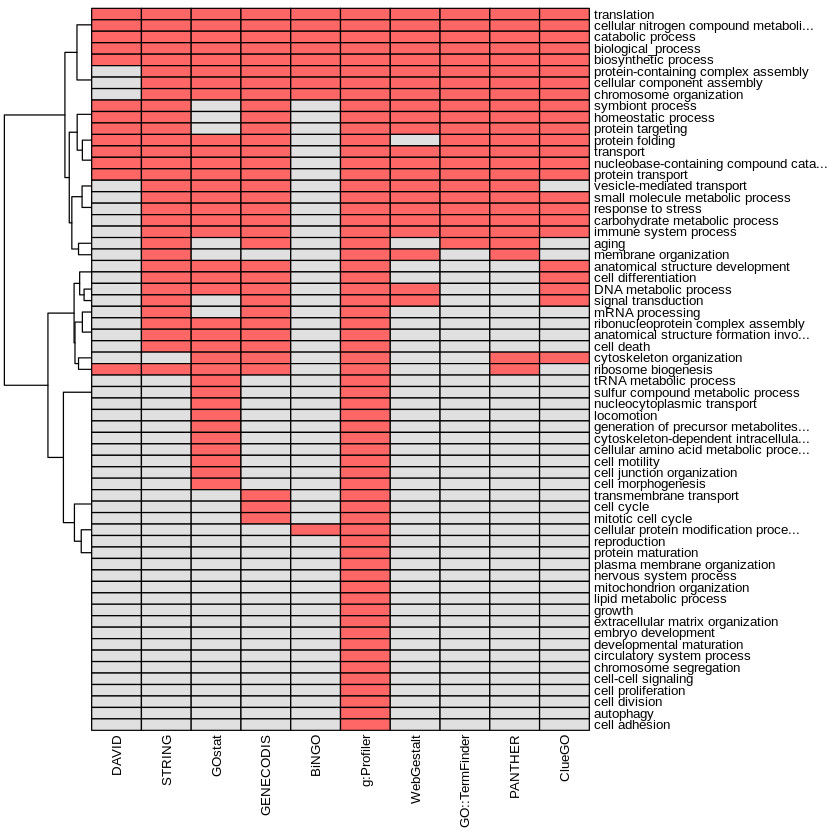

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "EGCG") %>% plot_bin()

##### MF

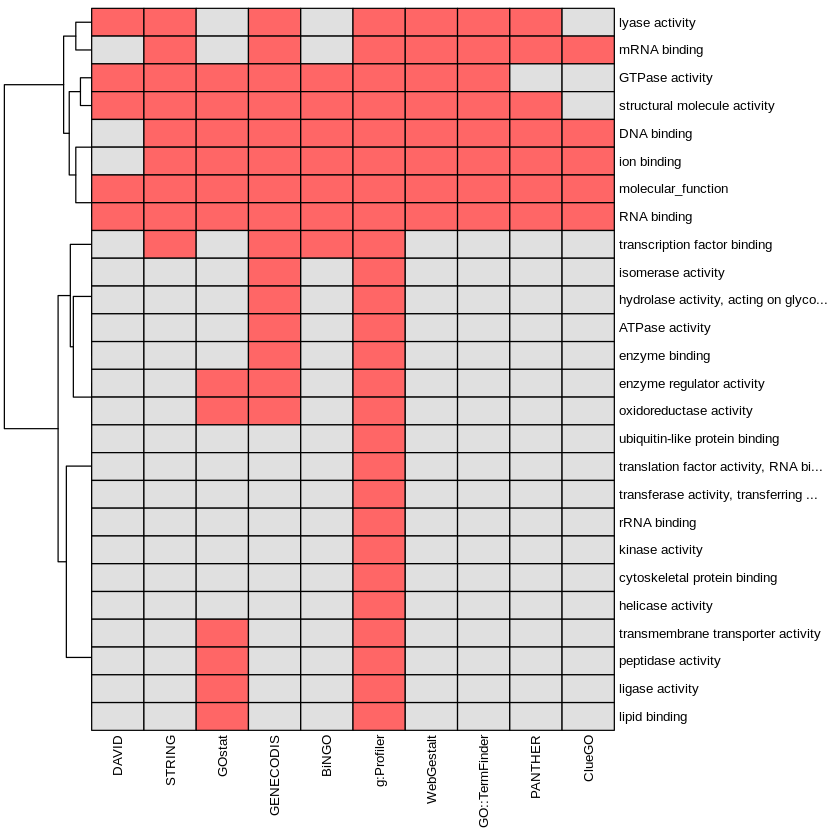

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "EGCG") %>% plot_bin()

##### CC

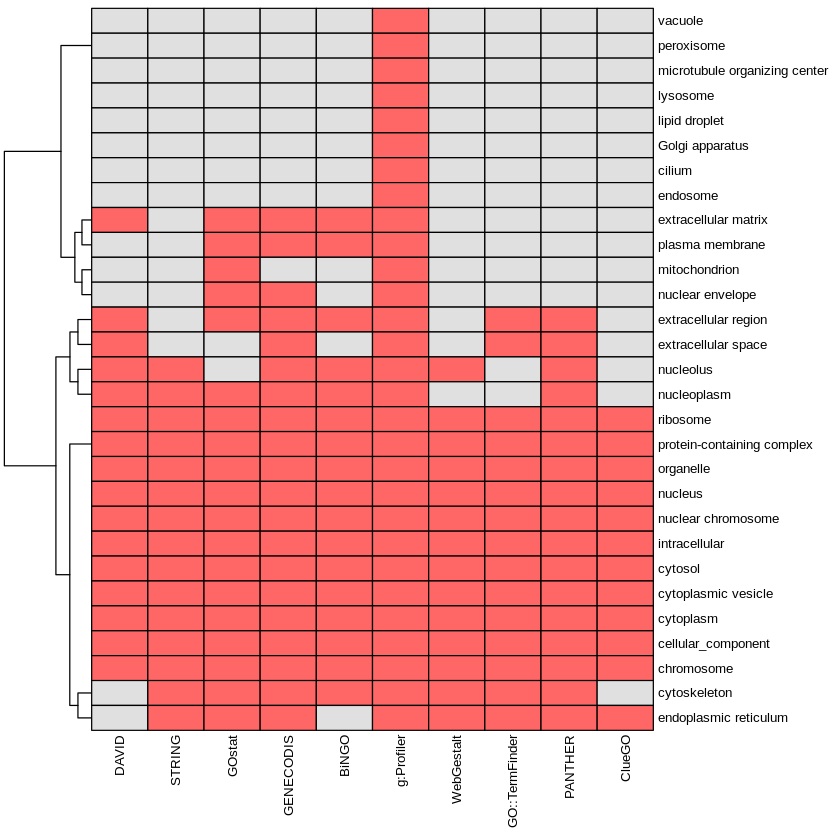

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "CC") %>% filter(Dataset == "EGCG") %>% plot_bin()

#### Caffeine Dataset

##### BP

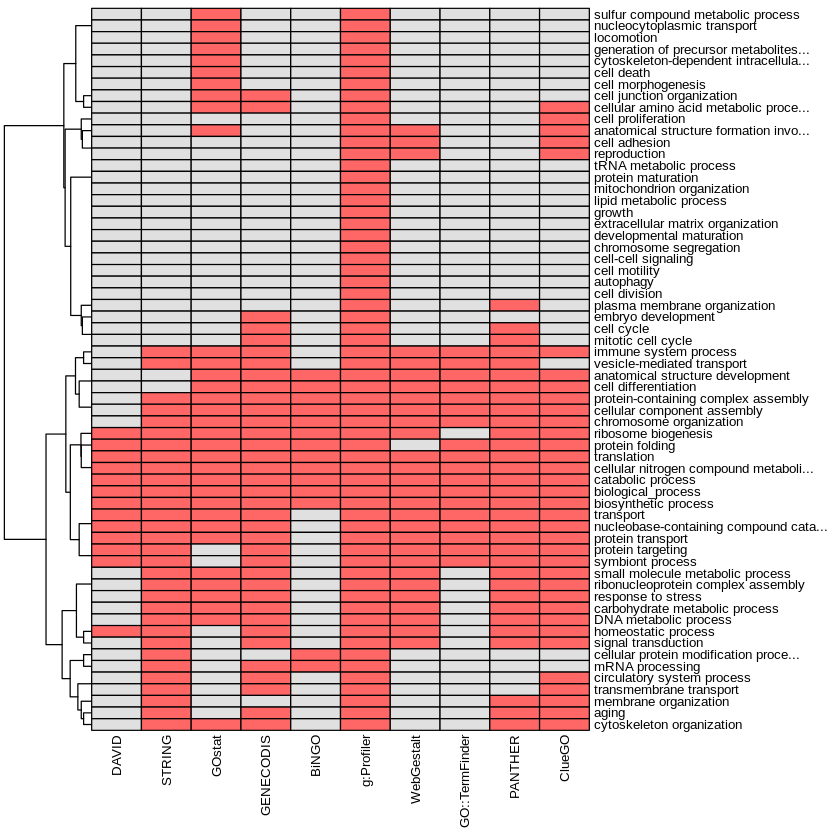

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "Caffeine") %>% plot_bin()

##### MF

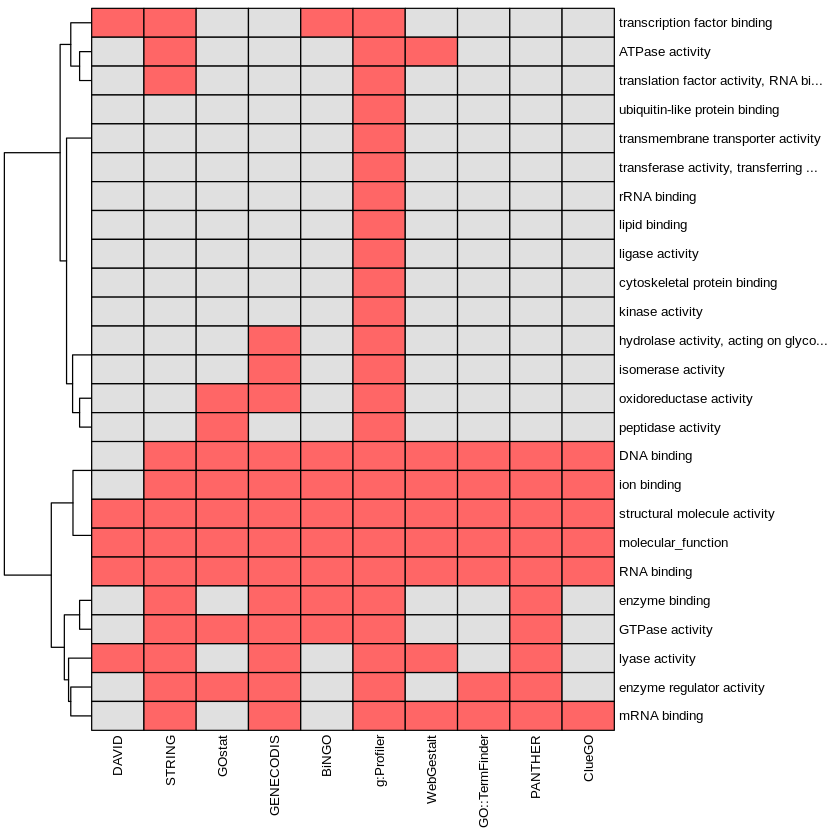

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "Caffeine") %>% plot_bin()

##### CC

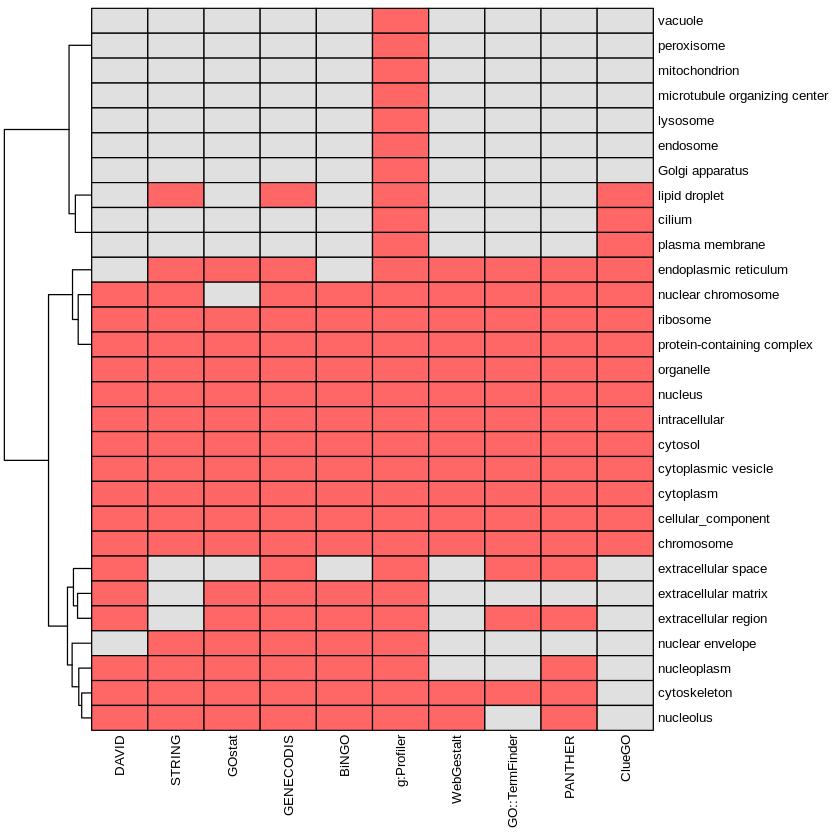

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "CC") %>% filter(Dataset == "Caffeine") %>% plot_bin()

### Present tools vs Prevously Found

#### EGCG *Dataset*

##### BP

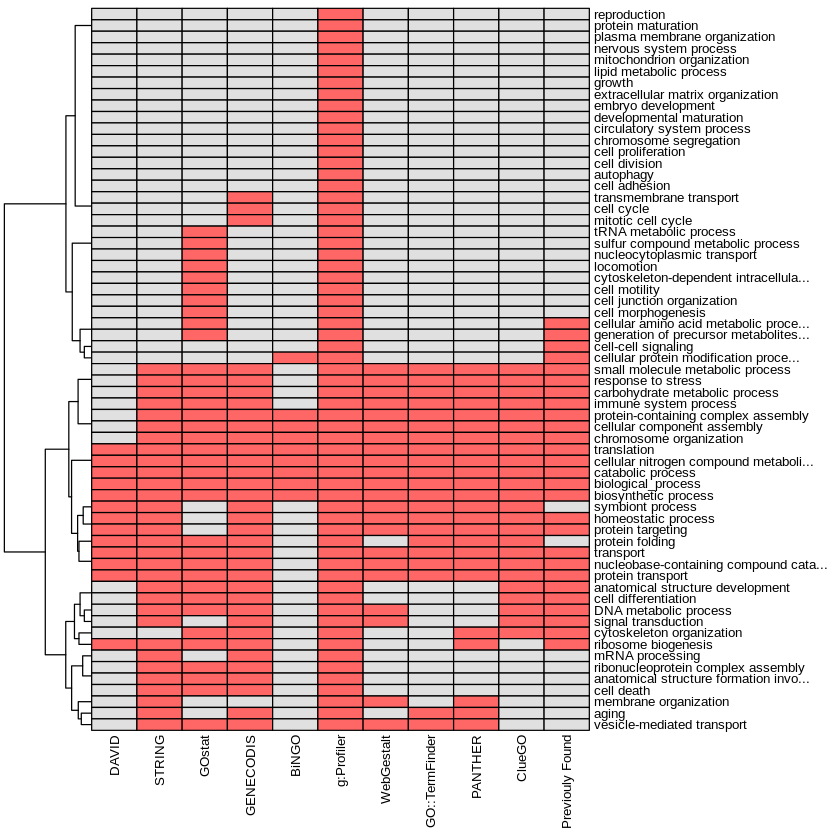

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "EGCG") %>% plot_bin_02()

##### MF

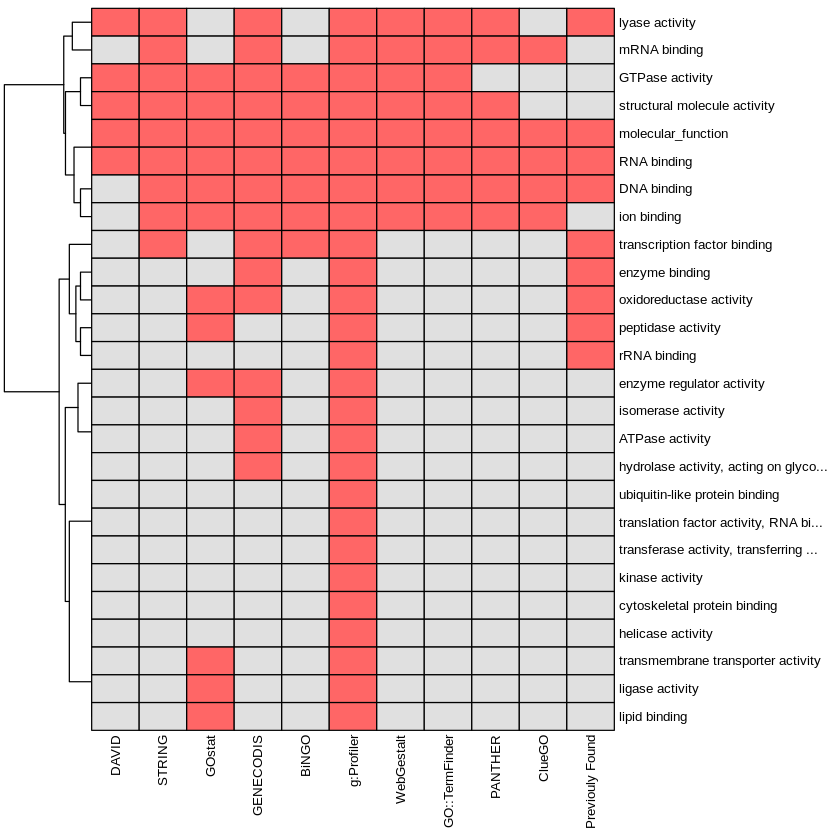

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "EGCG") %>% plot_bin_02()

#### Caffeine Dataset

##### BP

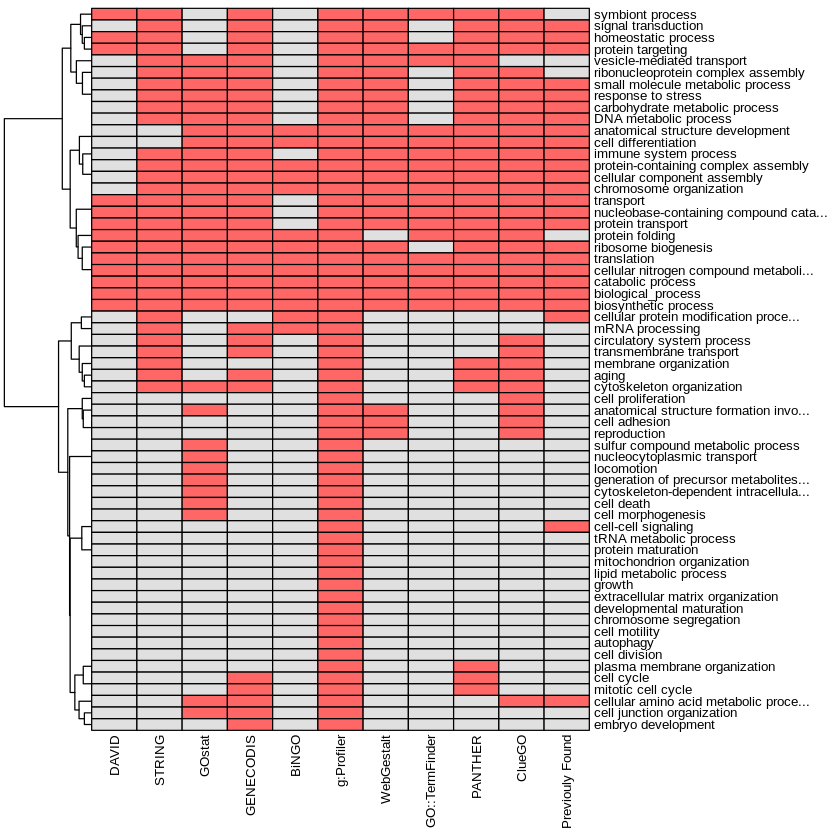

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "Caffeine") %>% plot_bin_02()

##### MF

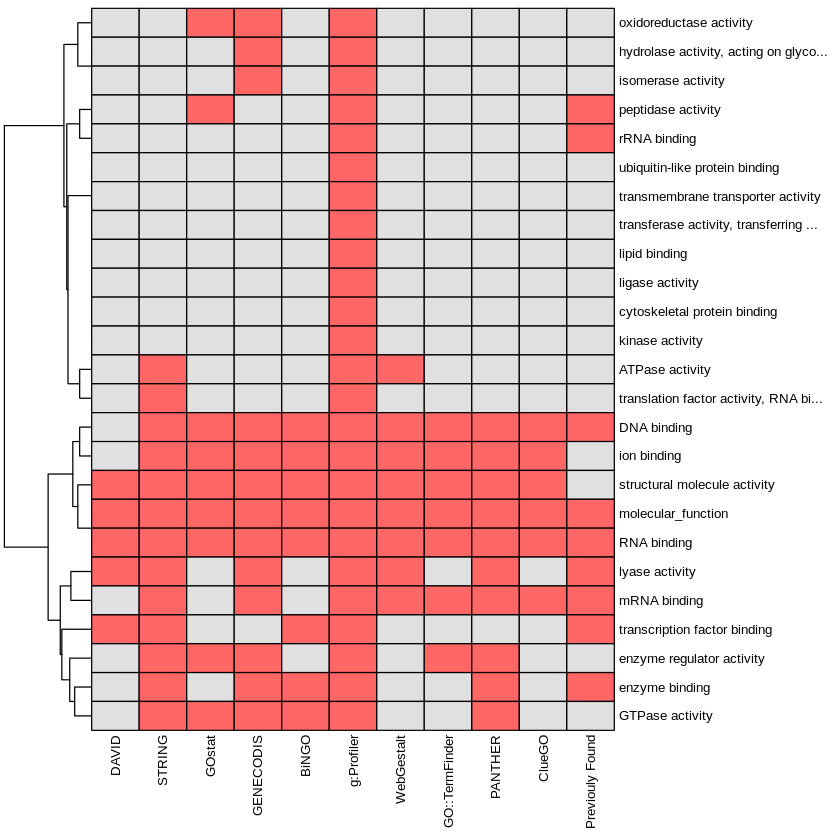

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "Caffeine") %>% plot_bin_02()

# **The Information content of Identified GO terms**

In [4]:
all_IC <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-Genes) %>% unique() %>% filter(.,FDR < 0.05) %>% filter(.,Enrichment == "All (Up vs. Down)") %>% setnames("Group","Dataset")
head(all_IC)

GOID,Description,FDR,Database,Type,Enrichment,Dataset
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
GO:0008301,"DNA binding, bending",0.0499,STRING,MF,All (Up vs. Down),EGCG
GO:0005544,calcium-dependent phospholipid binding,0.0499,GOstat,MF,All (Up vs. Down),EGCG
GO:0035986,senescence-associated heterochromatin focus assembly,0.0499,GO::TermFinder,BP,All (Up vs. Down),EGCG
GO:0042886,amide transport,0.0498,GO::TermFinder,BP,All (Up vs. Down),EGCG
GO:0030163,protein catabolic process,0.0498,g:Profiler,BP,All (Up vs. Down),EGCG
GO:0050920,regulation of chemotaxis,0.0497,g:Profiler,BP,All (Up vs. Down),EGCG


In [5]:
P <- toTable(GOBPOFFSPRING)
names(P) <- c("child","parent")
P_count <- as.data.frame(table(P$parent))
P_count$type <- "BP"

C <- toTable(GOCCOFFSPRING)
names(C) <- c("child","parent")
C_count <- as.data.frame(table(C$parent))
C_count$type <- "CC"

M <- toTable(GOMFOFFSPRING) 
names(M) <- c("child","parent") 
M_count <- as.data.frame(table(M$parent))
M_count$type <- "MF"

ref <- rbind(M_count,C_count,P_count)


IC <- function(id,onto){
  cnt <- dplyr::filter(ref, Var1 == i) %>% dplyr::select(Freq) %>% as.numeric()
  df <- AnnotationDbi::select(GO.db, keys(GO.db, "GOID"),  columns = c("ONTOLOGY"))
  df_02 <- as.data.frame(table(df$ONTOLOGY)) %>% dplyr::filter(.,Var1 == onto) 
  all_onto <- as.numeric(df_02[,2])
  if (is.na(cnt) == T) {
    #all GO term in select ontology
    prob <- 1/all_onto
    IC <- -log2(prob)
    return(IC)
  } else {
   prob <- (cnt+1)/all_onto
    IC <- -log2(prob)
    return(IC)
  }
}

In [ ]:
list <- all_IC %>% dplyr::filter(.,FDR < 0.05,Type == "MF") %>% dplyr::select(GOID) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"MF")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_MF <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_MF) <- c("IC","id")


In [ ]:
list <- all_IC %>% dplyr::filter(.,FDR < 0.05,Type == "CC") %>% dplyr::select(GOID) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"CC")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_CC <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")  
names(big_data_CC) <- c("IC","id")

In [ ]:
list <- all_IC %>% dplyr::filter(.,FDR < 0.05,Type == "BP") %>% dplyr::select(GOID) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"BP")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_BP <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_BP) <- c("IC","id")

In [ ]:
names(big_data_BP) <- c("IC","id")
names(big_data_CC) <- c("IC","id")
names(big_data_MF) <- c("IC","id")
IC <- rbind(big_data_BP,big_data_CC,big_data_MF) %>% setnames(c("IC","id"),c("IC","GOID"))
head(IC)
merge_01 <- inner_join(all_IC,IC,by= "GOID")
merge_01$IC <- as.numeric(merge_01$IC)
merge_01$Condition <- ifelse(merge_01$FDR < 0.05,"Significant","Unsignificant")
merge_02 <- merge_01 %>% setnames("IC","Information_Content")

merge_EGCG <- merge_02 %>% filter(.,Condition == "Significant") %>%
  group_by(Database,Type,Dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,Dataset == "EGCG")



merge_Caffeine <- merge_02 %>% filter(.,Condition == "Significant") %>%
  group_by(Database,Type,Dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,Dataset == "Caffeine")

In [73]:
merge_02 %>% filter(.,Condition == "Significant") %>% group_by(Dataset,Type) %>% summarise(CNT=n())
merge_02 %>% filter(.,Condition == "Significant") %>% summary()

`summarise()` regrouping output by 'Dataset' (override with `.groups` argument)



Dataset,Type,CNT
<chr>,<chr>,<int>
Caffeine,BP,2276
Caffeine,CC,775
Caffeine,MF,488
EGCG,BP,2861
EGCG,CC,975
EGCG,MF,542


     GOID           Description             FDR              Database        
 Length:7917        Length:7917        Min.   :0.0000000   Length:7917       
 Class :character   Class :character   1st Qu.:0.0000712   Class :character  
 Mode  :character   Mode  :character   Median :0.0057600   Mode  :character  
                                       Mean   :0.0131486                     
                                       3rd Qu.:0.0240000                     
                                       Max.   :0.0499000                     
     Type            Enrichment          Dataset          Information_Content
 Length:7917        Length:7917        Length:7917        Min.   : 0.000     
 Class :character   Class :character   Class :character   1st Qu.: 6.144     
 Mode  :character   Mode  :character   Mode  :character   Median : 8.975     
                                                          Mean   : 8.881     
                                                          3rd Qu

[1] "#0000FFFF" "#B38BFFFF" "#FFFFFFFF" "#FF9E81FF" "#FF0000FF"

 Biological Process Cellular Component Molecular Function
 Min.   : 6.362     Min.   : 5.611     Min.   : 8.985    
 1st Qu.: 6.985     1st Qu.: 6.141     1st Qu.:10.100    
 Median : 8.115     Median : 7.864     Median :11.152    
 Mean   : 8.633     Mean   : 7.845     Mean   :11.255    
 3rd Qu.:10.027     3rd Qu.: 8.598     3rd Qu.:12.444    
 Max.   :11.858     Max.   :10.744     Max.   :13.444    

Warning message:
“The input is a data frame, convert it to the matrix.”


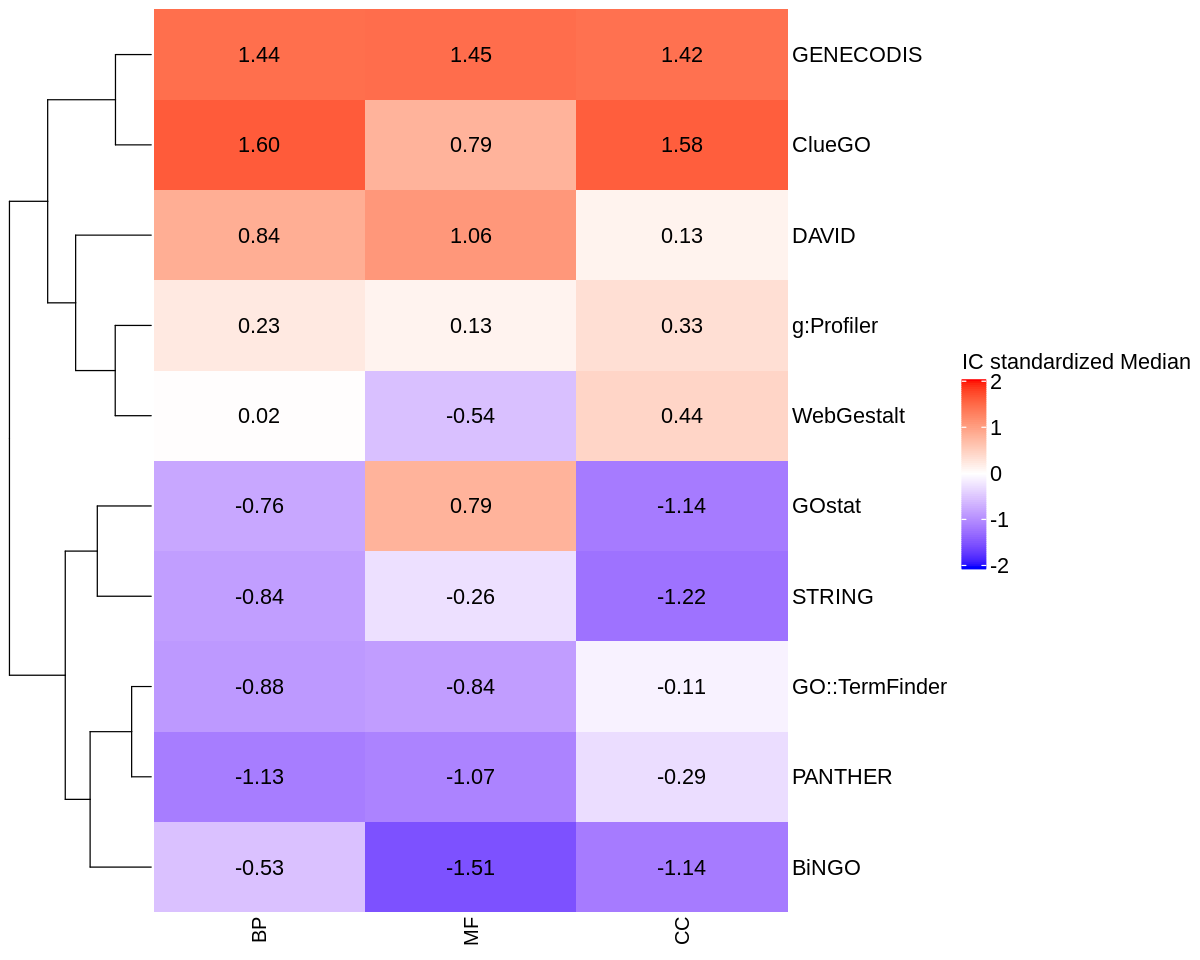

In [109]:
#EGCG
col_fun = colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
col_fun(seq(-2, 2))

EGCG_cor <- reshape(merge_EGCG[,-3],idvar = c("Database"),timevar = "Type",direction = "wide")
names(EGCG_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
EGCG_cor.01 <- EGCG_cor[,-1]
rownames(EGCG_cor.01) <- EGCG_cor[,1]
summary(EGCG_cor.01)
EGCG_cor.01$BP <- scale(EGCG_cor.01$`Biological Process`)
EGCG_cor.01$MF <- scale(EGCG_cor.01$`Molecular Function`)
EGCG_cor.01$CC <- scale(EGCG_cor.01$`Cellular Component`)

EGCG_cor.02 <- EGCG_cor.01[,-c(1:3)]

row_dend = hclust(dist(EGCG_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(EGCG_cor.02)),method = "complete") # column clustering

row.names(EGCG_cor.02) <- factor(row.names(EGCG_cor.02), levels=c("PANTHER","g:Profiler","GO::TermFinder",
                                                    "BiNGO","GOstat","STRING","ClueGO",
                                                    "GENECODIS","DAVID","WebGestalt"))
options(repr.plot.width=10, repr.plot.height=8)
col_fun = colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
#col_fun(seq(-2, 2))

Heatmap(EGCG_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"), 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", EGCG_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "average",
        cluster_columns = FALSE)


In [ ]:
#Caffeine
Caf_cor <- reshape(merge_Caffeine[,-3],idvar = c("Database"),timevar = "Type",direction = "wide")
names(Caf_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
Caf_cor.01 <- Caf_cor[,-1]
rownames(Caf_cor.01) <- Caf_cor[,1]
head(merge_02)
summary(Caf_cor.01)
Caf_cor.01$BP <- scale(Caf_cor.01$`Biological Process`)
Caf_cor.01$MF <- scale(Caf_cor.01$`Molecular Function`)
Caf_cor.01$CC <- scale(Caf_cor.01$`Cellular Component`)

Caf_cor.02 <- Caf_cor.01[,-c(1:3)]

row_dend = hclust(dist(Caf_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(Caf_cor.02)),method = "complete") # column clustering

row.names(Caf_cor.02) <- factor(row.names(Caf_cor.02), levels=c("PANTHER","g:Profiler","GO::TermFinder",
                                                    "BiNGO","GOstat","STRING","ClueGO",
                                                    "GENECODIS","DAVID","WebGestalt"))

Heatmap(Caf_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"),
       cluster_columns = FALSE, 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", Caf_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "average")

In [ ]:
#Within Dataset
within_IC <- merge_02[,-c(2,3,6,9)]
within_IC_index <- merge_02[,-c(1,2,3,4,6,8,9)] %>% unique()
head(within_IC_index)
head(within_IC)

Type,Dataset
<chr>,<chr>
MF,EGCG
BP,EGCG
CC,EGCG
BP,Caffeine
CC,Caffeine
MF,Caffeine


GOID,Database,Type,Dataset,Information_Content
<chr>,<chr>,<chr>,<chr>,<dbl>
GO:0008301,STRING,MF,EGCG,11.122569
GO:0005544,GOstat,MF,EGCG,13.444497
GO:0035986,GO::TermFinder,BP,EGCG,14.858127
GO:0042886,GO::TermFinder,BP,EGCG,5.646238
GO:0030163,g:Profiler,BP,EGCG,7.688202
GO:0050920,g:Profiler,BP,EGCG,7.963309


In [ ]:
datalist <- list()
for (i in 1:nrow(within_IC_index)) {
all.test.01 <- within_IC %>% filter(.,Type == within_IC_index[i,1] %>% unlist(),
                                      Dataset == within_IC_index[i,2] %>% unlist())
head(all.test.01)
res.aov <- aov(Information_Content ~ Database, data = all.test.01)
model=lm( all.test.01$Information_Content ~ all.test.01$Database )
     ANOVA=aov(model)
TUKEY <- TukeyHSD(x=ANOVA, 'all.test.01$Database', conf.level=0.95) 
TUKEY.02 <- TUKEY$`all.test.01$Database` %>% as.data.frame() %>% select(-diff,-lwr,-upr)
TUKEY.03 <- t(TUKEY.02) %>% as.data.frame()
rownames(TUKEY.03) <- NULL
res <- cbind(tidy(res.aov)[-2,],TUKEY.03)[,-c(1,2,3,4)]
res$Type <- within_IC_index[i,1] %>% unlist()
res$Dataset <-within_IC_index[i,2] %>% unlist()
datalist[[i]] <- res
}

res.01 <- do.call(rbind,datalist) %>% unique()
print(res.01)



In [178]:
#Between Dataset
tool_list <- merge_02$Database %>% unique()
p_value <- list()
for (i in tool_list) {
  print(i)
  x <- merge_02 %>% filter(Database == i, Type == "MF")
  res <- t.test(Information_Content ~ Dataset, data = x, var.equal = TRUE)
  #print(res$p.value)
  #print(res$statistic)
  p_value[i] <- res$p.value
}

[1] "STRING"
[1] "GOstat"
[1] "GO::TermFinder"
[1] "g:Profiler"
[1] "GENECODIS"
[1] "BiNGO"
[1] "PANTHER"
[1] "WebGestalt"
[1] "DAVID"
[1] "ClueGO"


In [179]:
res_p <- p.adjust(p_value,method="bonferroni") 
res_p %>% as.data.frame()

,.
,<dbl>
STRING,1
GOstat,1
GO::TermFinder,1
g:Profiler,1
GENECODIS,1
BiNGO,1
PANTHER,1
WebGestalt,1
DAVID,1


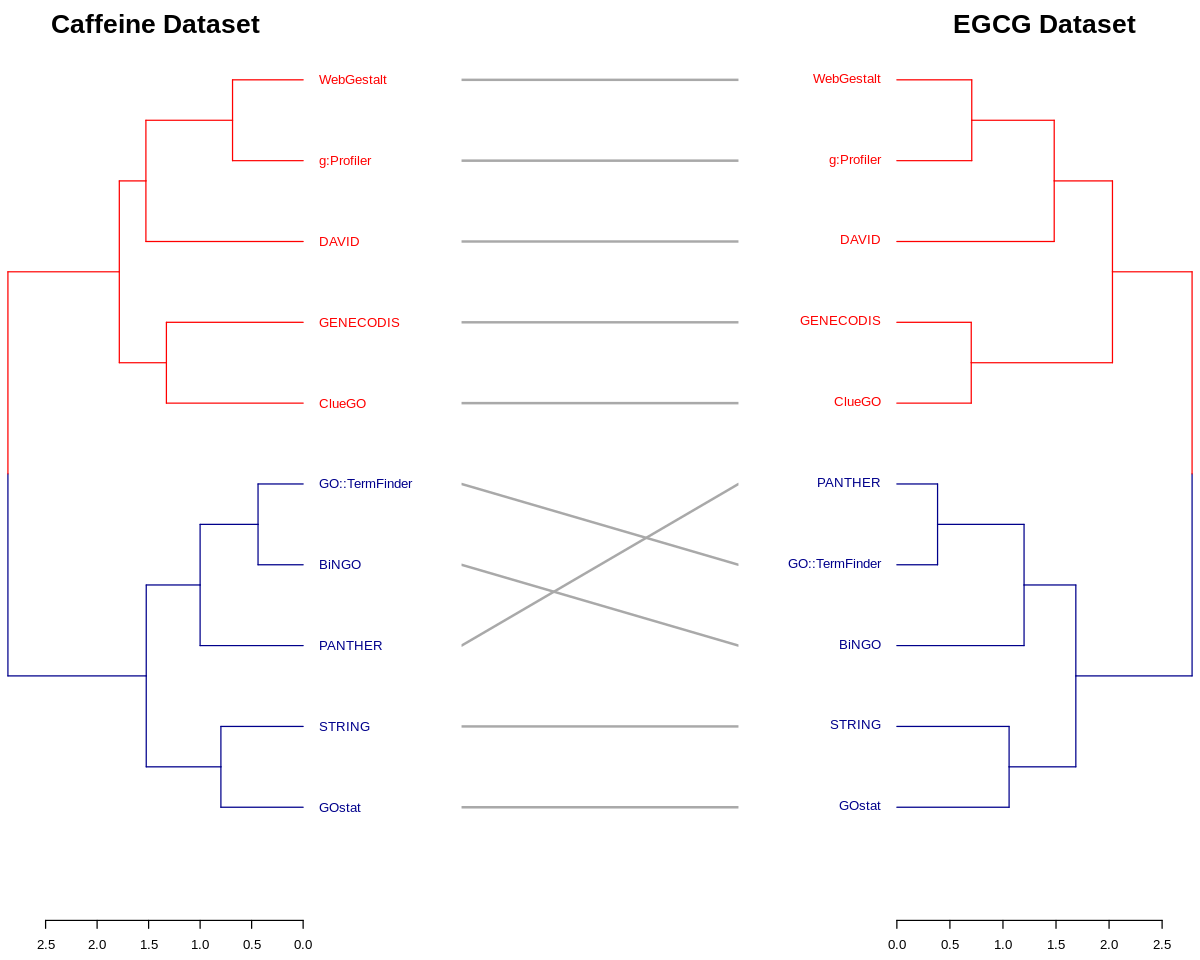

In [144]:
d1 <- Caf_cor.02 %>% dist() %>% hclust( method="average" ) %>% as.dendrogram()
d2 <- EGCG_cor.02 %>% dist() %>% hclust( method="average" ) %>% as.dendrogram()

# Custom these kendo, and place them in a list
dl <- dendlist(
  d1 %>% 
    set("labels_col", value = c("darkblue", "red"), k=2) %>%
    set("branches_lty", 1) %>%
    set("branches_k_color", value = c("darkblue", "red"), k = 2),
  d2 %>% 
    set("labels_col", value = c("darkblue", "red"), k=2) %>%
    set("branches_lty", 1) %>%
    set("branches_k_color", value = c("darkblue", "red"), k = 2)
)

# Plot them together
tanglegram(dl, 
           common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, highlight_branches_lwd=FALSE, 
           margin_inner=10,
           lwd=2,
   main_left = "Caffeine Dataset",
   main_right = "EGCG Dataset"
)


# **Rank difference and p-value distribution of identified GO terms**

In [ ]:
all <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-Genes) %>% unique() %>% filter(.,FDR < 0.05) %>% filter(.,Enrichment == "All (Up vs. Down)") %>% setnames("Group","Dataset")

## One-way ANOVA test

### F-test plus Pairwise

In [ ]:
Caffeine.test <- all[,-c(2,6)] %>% filter(.,Dataset == "Caffeine") %>% unique() 
EGCG.test <- all[,-c(2,6)] %>% filter(.,Dataset == "EGCG") %>% unique()

all.test <- rbind(Caffeine.test,EGCG.test)[,-c(1,2)] %>% unique()
head(all.test)
all.test.99 <- rbind(Caffeine.test,EGCG.test)
head(all.test.99)

Database,Type,Dataset
<chr>,<chr>,<chr>
DAVID,BP,Caffeine
DAVID,CC,Caffeine
DAVID,MF,Caffeine
g:Profiler,BP,Caffeine
GENECODIS,MF,Caffeine
g:Profiler,MF,Caffeine


GOID,FDR,Database,Type,Dataset
<chr>,<dbl>,<chr>,<chr>,<chr>
GO:0000184,2.79e-11,DAVID,BP,Caffeine
GO:0000502,1.07e-02,DAVID,CC,Caffeine
GO:0000785,6.25e-03,DAVID,CC,Caffeine
GO:0001895,1.60e-02,DAVID,BP,Caffeine
GO:0003723,2.65e-05,DAVID,MF,Caffeine
GO:0003735,6.51e-09,DAVID,MF,Caffeine


In [ ]:
datalist <- list()
for (i in 1:nrow(all.test)) {
     all.test.01 <- all.test.99 %>% filter(.,Type == all.test[i,2] %>% unlist(),
                                            Dataset == all.test[i,3] %>% unlist())
     res.aov <- aov(FDR ~ Database, data = all.test.01)
     # What is the effect of the treatment on the value ?
       
     model=lm( all.test.01$FDR ~ all.test.01$Database )
     ANOVA=aov(model)
       
         # Tukey test to study each pair of treatment :
      TUKEY <- TukeyHSD(x=ANOVA, 'all.test.01$Database', conf.level=0.95) 
      TUKEY.02 <- TUKEY$`all.test.01$Database` %>% as.data.frame() %>% select(-diff,-lwr,-upr)
      TUKEY.03 <- t(TUKEY.02) %>% as.data.frame()
      rownames(TUKEY.03) <- NULL
      res <- cbind(tidy(res.aov)[-2,],TUKEY.03)[,-c(1,2,3,4)]
      res$Type <- all.test[i,2] %>% unlist()
      res$Dataset <-all.test[i,3] %>% unlist()
      datalist[[i]] <- res
}

res.01 <- do.call(rbind,datalist) %>% unique()
head(res.01)

,statistic,p.value,ClueGO-BiNGO,DAVID-BiNGO,g:Profiler-BiNGO,GENECODIS-BiNGO,GO::TermFinder-BiNGO,GOstat-BiNGO,PANTHER-BiNGO,STRING-BiNGO,⋯,STRING-GO::TermFinder,WebGestalt-GO::TermFinder,PANTHER-GOstat,STRING-GOstat,WebGestalt-GOstat,STRING-PANTHER,WebGestalt-PANTHER,WebGestalt-STRING,Type,Dataset
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,15.667726,4.278093e-25,3.058117e-06,0.2333250,0.6510767,0.9166698,6.271395e-07,9.283504e-01,0.05249149,0.89830470,⋯,3.434492e-06,0.0005238057,2.051383e-07,0.01121679,0.0002145768,0.4739237,0.9936163,0.9869211,BP,Caffeine
2,5.403629,3.357487e-07,2.136164e-01,1.0000000,0.8815575,0.4083356,6.449004e-01,9.999988e-01,0.98482758,0.87034645,⋯,9.999903e-01,0.9881271531,8.839626e-01,0.61740369,0.9845446688,0.9999455,1.0000000,0.9996183,CC,Caffeine
3,3.984883,6.429465e-05,4.328915e-02,0.9999734,0.9755742,0.8052857,9.360171e-01,9.971536e-01,0.87599699,1.00000000,⋯,8.944730e-01,0.4622908132,9.996248e-01,0.99544926,0.7724543010,0.7716635,0.3100668,0.9909100,MF,Caffeine
31,4.343735,1.779697e-05,7.217851e-02,0.8803424,0.3847858,0.9998741,3.792236e-01,1.000000e+00,0.99999999,0.93889563,⋯,9.896771e-01,0.9996403488,9.999999e-01,0.90212069,0.8740436397,0.7434261,0.7245159,1.0000000,MF,EGCG
33,17.499948,1.668489e-28,1.573060e-04,0.9385155,0.9999996,1.0000000,5.642368e-01,4.454725e-06,0.97721110,1.00000000,⋯,1.743208e-01,0.9285716438,0.000000e+00,0.00000000,0.0000000000,0.8348154,0.9999999,0.9758365,BP,EGCG
36,5.624958,1.326195e-07,6.272287e-03,0.3673167,0.8849485,0.9973649,3.786242e-02,9.998395e-01,0.04448666,0.01342918,⋯,1.000000e+00,0.9998569308,1.374524e-01,0.04574920,0.7466597409,0.9999562,0.9999992,0.9993060,CC,EGCG


### Display Mean

In [ ]:
me.tools <- all %>% group_by(Dataset,Database,Type) %>% dplyr::summarise(me=median(FDR),sd=sd(FDR)) %>% as.data.frame()
me.tools <- me.tools[order(me.tools$me,me.tools$sd),]
me.tools[,c(4,5)] <- round(me.tools[,c(4,5)], 8)
me.tools[,5] <- round(me.tools[,5], 4)
me.tools[,c(4,5)] <- format(me.tools[,c(4,5)], scientific = T)
me.tools$sumstat <- paste0(me.tools$me," ","(",me.tools$sd,")")

res.me <- reshape(me.tools[,-c(4,5)],idvar = c("Dataset","Type"),timevar = "Database",direction = "wide")
head(res.me)

`summarise()` regrouping output by 'Dataset', 'Database' (override with `.groups` argument)



,Dataset,Type,sumstat.DAVID,sumstat.ClueGO,sumstat.GO::TermFinder,sumstat.PANTHER,sumstat.WebGestalt,sumstat.GOstat,sumstat.STRING,sumstat.BiNGO,sumstat.g:Profiler,sumstat.GENECODIS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
7,Caffeine,BP,6.0000e-08 (5.80e-03),1.4300e-03 (3.60e-03),7.4800e-06 (5.20e-03),7.3300e-04 (1.36e-02),3.8100e-03 (1.40e-02),1.7700e-02 (1.38e-02),7.3000e-03 (1.46e-02),1.2300e-02 (1.44e-02),3.4200e-03 (1.54e-02),1.6850e-02 (1.67e-02)
37,EGCG,BP,4.2000e-07 (1.30e-02),2.7700e-04 (8.00e-04),8.8500e-04 (1.45e-02),6.3100e-03 (1.40e-02),6.5700e-03 (1.49e-02),3.3700e-02 (1.47e-02),1.5100e-02 (1.33e-02),9.2950e-03 (1.43e-02),1.0700e-02 (1.57e-02),1.4400e-02 (1.47e-02)
36,EGCG,MF,1.0700e-02 (1.30e-02),2.1400e-06 (1.00e-04),1.2100e-02 (1.15e-02),3.1400e-02 (1.66e-02),1.5500e-02 (1.20e-02),1.2350e-02 (1.86e-02),8.1000e-03 (1.69e-02),2.5400e-02 (1.71e-02),8.6100e-03 (1.43e-02),2.9300e-02 (1.60e-02)
5,Caffeine,CC,1.3150e-04 (1.50e-02),1.3370e-05 (1.10e-03),3.3600e-04 (9.40e-03),1.2645e-04 (1.12e-02),2.9400e-04 (1.15e-02),4.1900e-04 (1.48e-02),9.2000e-04 (8.40e-03),1.0350e-03 (1.28e-02),1.9300e-03 (1.54e-02),4.6000e-03 (1.68e-02)
35,EGCG,CC,3.6750e-04 (1.10e-02),1.5950e-05 (5.00e-04),1.1800e-03 (1.20e-02),2.4000e-03 (1.22e-02),4.6500e-03 (1.22e-02),2.8650e-03 (1.68e-02),3.3000e-03 (9.90e-03),5.5000e-03 (1.79e-02),4.7000e-03 (1.48e-02),1.3300e-02 (1.56e-02)
6,Caffeine,MF,8.1800e-03 (1.67e-02),4.0600e-04 (3.60e-03),8.5000e-03 (1.49e-02),1.0850e-02 (1.26e-02),2.2900e-02 (1.75e-02),8.5000e-03 (1.57e-02),1.4300e-02 (1.36e-02),2.1800e-02 (1.37e-02),7.7700e-03 (1.58e-02),2.4600e-02 (1.97e-02)


## Display Plot

`summarise()` regrouping output by 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'Database' (override with `.groups` argument)



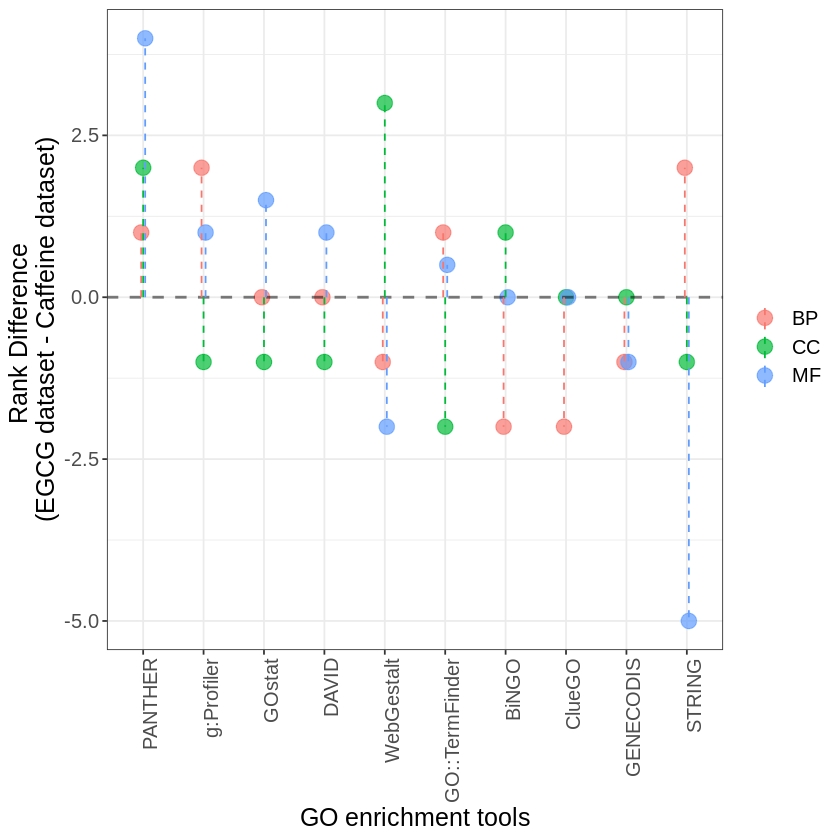

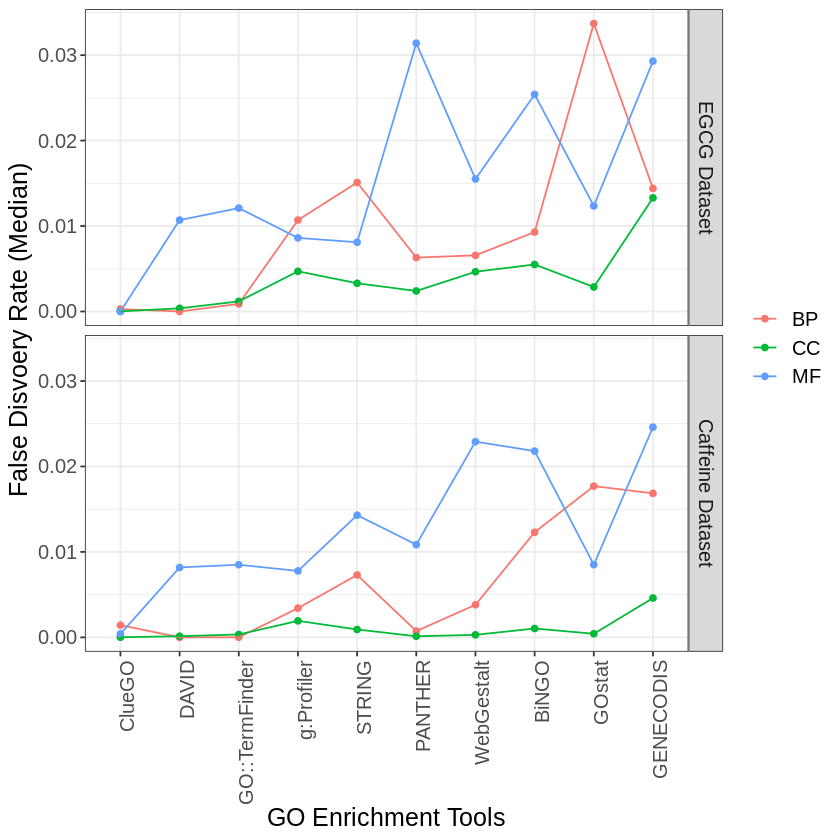

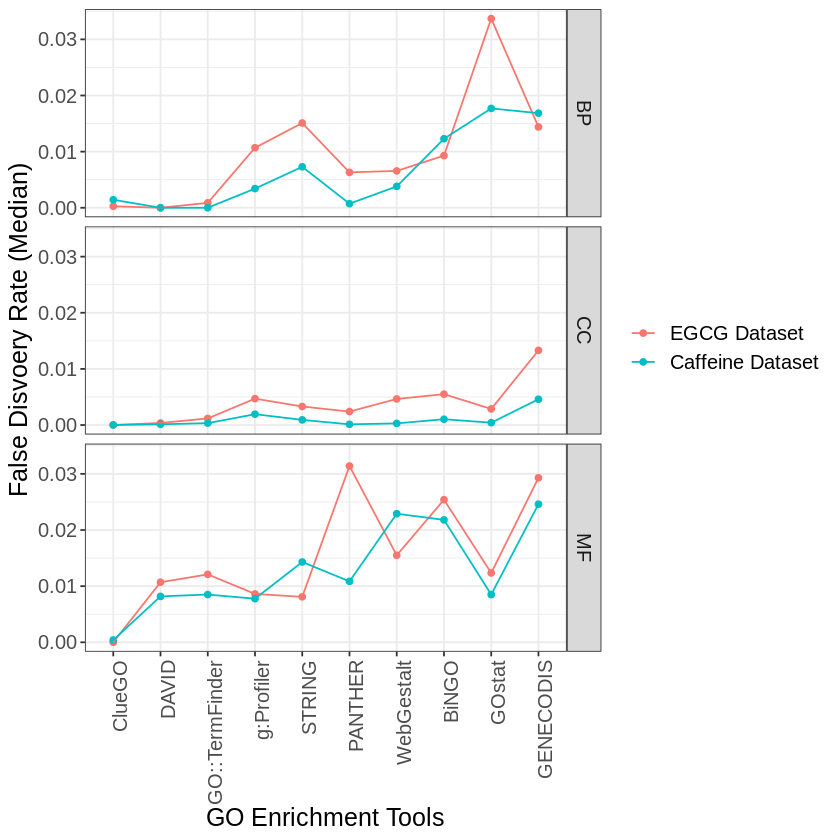

In [ ]:
Caffeine <- all  %>% filter(.,Dataset == "Caffeine") %>% unique() %>%
  group_by(Database,Type) %>% summarise(Caffeine=median(FDR)) %>% as.data.frame()

Caffeine_BP <- filter(Caffeine,Type == "BP") 
Caffeine_BP$Rank <- rank(Caffeine_BP$Caffeine)

Caffeine_CC <- filter(Caffeine,Type == "CC") 
Caffeine_CC$Rank <- rank(Caffeine_CC$Caffeine)

Caffeine_MF <- filter(Caffeine,Type == "MF") 
Caffeine_MF$Rank <- rank(Caffeine_MF$Caffeine)

aCaf <- rbind(Caffeine_BP,Caffeine_CC,Caffeine_MF)

EGCG <- all  %>% filter(.,Dataset == "EGCG") %>% unique() %>%
  group_by(Database,Type) %>% summarise(EGCG=median(FDR)) %>% as.data.frame()


EGCG_BP <- filter(EGCG,Type == "BP") 
EGCG_BP$Rank <- rank(EGCG_BP$EGCG)

EGCG_CC <- filter(EGCG,Type == "CC") 
EGCG_CC$Rank <- rank(EGCG_CC$EGCG)

EGCG_MF <- filter(EGCG,Type == "MF") 
EGCG_MF$Rank <- rank(EGCG_MF$EGCG)

aeg <- rbind(EGCG_BP,EGCG_CC,EGCG_MF)


final_all <-  cbind(aeg,aCaf)[,-c(5,6)]
names(final_all) <- c("Database","Type","EGCG","EGCG rank","Caffeine","Caffeine rank")


final_all$diff_rank <- final_all$`EGCG rank` - final_all$`Caffeine rank`

final_02 <- final_all[,-c(3:6)] %>% melt(.,id.vars = c("Database","Type")) 


ggplot(data=final_02, aes(x=reorder(Database,-value), y=value,color=Type)) +
  geom_point(aes(color=Type),size = 4,alpha = 0.7, position=position_dodge(width=0.1))+ 
  theme_bw() +
  geom_hline(yintercept=0, linetype="dashed", color = "black",size=0.8,alpha = 0.5) +
  geom_linerange(aes(x=Database,ymax=value, ymin=0),
                 linetype = "dashed",
                 size = 0.5,
                 position = position_dodge(width=0.1))+
  xlab("GO enrichment tools") +
  ylab("Rank Difference \n(EGCG dataset - Caffeine dataset)") +
  labs(color="") + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))

  


################ TEST #########################

df <- final_all[,-c(4,6,7)] 
names(df) <- c("database","type","EGCG Dataset","Caffeine Dataset")
df_02 <- melt(df,id.vars=c("database","type"))

ggplot(df_02,aes(x=reorder(database,value),y=value,color = type,group = type)) +
  geom_point() +
  geom_line() +
  facet_grid(vars(variable)) +
  theme_bw()+ 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("GO Enrichment Tools") +
  ylab("False Disvoery Rate (Median)") +
  labs(color="")+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))



ggplot(df_02,aes(x=reorder(database,value),y=value,color = variable,group = variable)) +
  geom_point() +
  geom_line() +
  facet_grid(rows=vars(type)) +
  theme_bw()+ 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("GO Enrichment Tools") +
  ylab("False Disvoery Rate (Median)") +
  labs(color="") + 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))